# Plotting results



## Setup


In [133]:
# Hello Max!

import numpy as np
import networkx as nx
from agent import Agent
from model import Model
from hybrid_networks import create_hybrid_network
from tqdm import tqdm
from hybrid_networks_clean import rewire_network, randomize_network_v2, create_hybrid_network

import pandas as pd
from pygam import LogisticGAM,LinearGAM, s   
from sklearn.model_selection import train_test_split

%load_ext autoreload
%autoreload 2                      

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
import opinionated
import matplotlib.pyplot as plt
plt.style.use("opinionated_j")
import colormaps as cmaps 

Now downloading: Roboto Condensed
Added new font as Roboto Condensed Light
Added new font as Roboto Condensed
Added new font as Roboto Condensed
Added new font as Roboto Condensed Black
Now downloading: Montserrat
Added new font as Montserrat Thin Light
Added new font as Montserrat Thin
Added new font as Montserrat Thin
Added new font as Montserrat Thin Black
Now downloading: Source Code Pro
Added new font as Source Code Pro ExtraLight Light
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight
Added new font as Source Code Pro ExtraLight Black
Now downloading: Fira Sans
Added new font as Fira Sans Light
Added new font as Fira Sans
Added new font as Fira Sans
Added new font as Fira Sans Black
Now downloading: Fira Sans Condensed
Added new font as Fira Sans Condensed Light
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed
Added new font as Fira Sans Condensed Black
Now downloading: IBM Plex Sans
Added new font as IBM Plex San

In [ ]:
def generate_markdown(data):
    markdown = []

    # Add general information
    markdown.append("## Model Summary Table\n")
    markdown.append("| | |")
    markdown.append("|-------------------------------|--------------|")
    markdown.append(f"| **Number of Samples:**                      | {np.round(data['n_samples'],3)}                                                       |")
    markdown.append(f"| **Number of Features:**                     | {np.round(data['m_features'],3)}                                                    |")
    markdown.append(f"| **Effective DoF:**                          | {np.round(data['edof'],3)}                                                    |")
    markdown.append(f"| **Log Likelihood:**                         | {np.round(data['loglikelihood'],3)}                                                |")
    markdown.append(f"| **AIC:**                                    | {np.round(data['AIC'],3)}                                                 |")
    markdown.append(f"| **AICc:**                                   | {np.round(data['AICc'],3)}                                                 |")
    markdown.append(f"| **GCV:**                                    | {np.round(data['GCV'],3)}                                                    |")
    markdown.append(f"| **Scale:**                                  | {np.round(data['scale'],3)}                                                    |")
    markdown.append(f"| **Pseudo R-Squared:**                       | {np.round(data['pseudo_r2']['explained_deviance'],3)}                                                    |")
    
    markdown.append("\n### Significance Codes\n")
    markdown.append("| Feature Function | SE | P > x | Sig. Code |")
    markdown.append("|------------------|--------|------|-------|-----------|")

    for i, (edof, se, p_value) in enumerate(zip(data['edof_per_coef'], data['se'], data['p_values'])):
        sig_code = ''
        if p_value < 0.001:
            sig_code = '***'
        elif p_value < 0.01:
            sig_code = '**'
        elif p_value < 0.05:
            sig_code = '*'
        elif p_value < 0.1:
            sig_code = '.'
        
        markdown.append(f"| **s({i})**         | {se:.6f}  | {edof:.6f}  | {p_value:.6f}  | {sig_code} |")

    markdown.append("\n*Significance codes: 0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1*")

    return "\n".join(markdown)

In [304]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

def plot_partial_dependence(gam, hex_colors, feature_names, max_cols=3, filename=None):
    """
    Plots partial dependence plots for all terms in a GAM model with a maximum number of columns,
    centering the last row if it is incomplete.
    
    Parameters:
    gam : object
        The generalized additive model object containing the terms and methods.
    hex_colors : list of str
        List of hex color codes to use for the plots.
    feature_names : list of str
        List of feature names corresponding to the terms in the model.
    max_cols : int
        Maximum number of columns per row in the subplot grid.
    """
    
    term_indices = [i for i, term in enumerate(gam.terms) if not term.isintercept]
    plot_count = len(term_indices)
    nrows = (plot_count + max_cols - 1) // max_cols

    fig = plt.figure(figsize=(5 * max_cols, 5 * nrows))
    m = max_cols
    gs = gridspec.GridSpec(nrows, m * max_cols)
    axs = []

    y_limits = []

    # First pass: compute the y-axis limits for all plots
    for I in term_indices:
        XX = gam.generate_X_grid(term=I)
        pdep, confi = gam.partial_dependence(term=I, X=XX, width=0.99)
        y_limits.append((min(pdep.min(), confi.min()), max(pdep.max(), confi.max())))

    global_y_min = min(limit[0] for limit in y_limits)
    global_y_max = max(limit[1] for limit in y_limits)

    # Create subplots
    for idx, I in enumerate(term_indices):
        row = idx // max_cols
        col = idx % max_cols
        last_row = nrows - 1

        # Apply centering offset only if the last row is incomplete
        if row == last_row and (plot_count % max_cols != 0):
            off = (m * (max_cols - (plot_count % max_cols))) // 2
        else:
            off = 0

        ax = plt.subplot(gs[row, m * col + off: m * (col + 1) + off])
        axs.append(ax)

        XX = gam.generate_X_grid(term=I)
        pdep, confi = gam.partial_dependence(term=I, X=XX, width=0.99)

        ax.plot(XX[:, gam.terms[I].feature], pdep, color=hex_colors[idx % len(hex_colors)])
        ax.plot(XX[:, gam.terms[I].feature], confi, color=hex_colors[idx % len(hex_colors)], ls='--')
        ax.fill_between(XX[:, gam.terms[I].feature], confi[:, 0], confi[:, 1], facecolor=hex_colors[idx % len(hex_colors)], alpha=0.2, interpolate=True)
        ax.set_ylim(global_y_min, global_y_max)
        ax.set_xlabel(feature_names[I])
        if col == 0:
            ax.set_ylabel('Partial Dependence')

    plt.tight_layout()

    if filename is not None:
        plt.savefig(filename, dpi=300, transparent=True)
    plt.show()
    
    
def plot_scatter_matrix(X, y, max_cols=3, filename=None):
    """
    Plots scatterplots of all columns in DataFrame X against the target vector y,
    with an adjustable number of columns per row and centering if the last row is incomplete.
    
    Parameters:
    X : DataFrame
        Input data with multiple columns.
    y : array-like
        Target variable data.
    max_cols : int
        Maximum number of columns per row in the subplot grid.
    """
    columns = X.columns
    target_name = y.columns[0]
    plot_count = len(columns)
    nrows = (plot_count + max_cols - 1) // max_cols

    fig = plt.figure(figsize=(5 * max_cols, 5 * nrows))
    m = max_cols
    gs = gridspec.GridSpec(nrows, m * max_cols)
    axs = []

    # Create subplots
    for idx, col in enumerate(columns):
        row = idx // max_cols
        col = idx % max_cols
        last_row = nrows - 1

        # Apply centering offset only if the last row is incomplete
        if row == last_row and (plot_count % max_cols != 0):
            off = (m * (max_cols - (plot_count % max_cols))) // 2
        else:
            off = 0

        ax = plt.subplot(gs[row, m * col + off: m * (col + 1) + off])
        axs.append(ax)

        ax.scatter(X.iloc[:, idx], y, c='#ab0b00', alpha=.2)
        ax.set_xlabel(columns[idx])
        if col == 0:
            ax.set_ylabel(target_name)

    plt.tight_layout()

    if filename is not None:
        plt.savefig(filename, dpi=300, transparent=True)
    plt.show()

In [282]:
output_dir = 'talk_munich/images/'

# Bayes-agent on Perceptron-data

## Plot the graphs & powerlaws

In [446]:
import dill

# Use dill to deserialize the graph from a file
with open('data_proc/perceptron_graph_pre_1979.pkl', 'rb') as f:
    G_perceptron = dill.load(f)


In [447]:
print(len(G_perceptron))

3519


In [346]:
randomize_by = [0,.1,.2,.4,.6,.8,1.]

In [348]:
import graph_tool.all as gt


for this_rand_value in randomize_by:
    G_randomized = randomize_network_v2(G_perceptron, p_rewiring=this_rand_value)
    # Convert NetworkX graph to graph_tool graph
    g = gt.Graph(directed=True)

    # Create a mapping from NetworkX nodes to graph_tool vertices
    node_map = {n: g.add_vertex() for n in G_randomized.nodes()}

    # Add edges to the graph_tool graph
    for u, v in G_randomized.edges():
        g.add_edge(node_map[u], node_map[v])
        
        
    pos = gt.sfdp_layout(g)
    dprms = dict(fmt="png",  output_size=(2000, 2000))
    gt.graph_draw( g, pos, output =output_dir + f"perceptron_graph_randomized_p={this_rand_value}.png",  output_size=(2000, 2000))


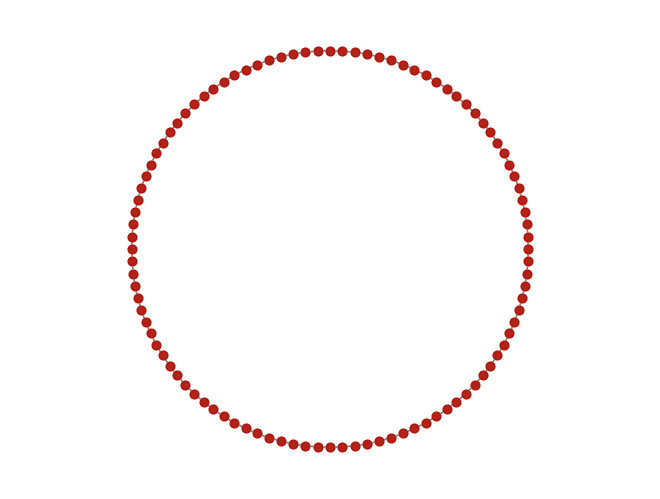

In [414]:
import matplotlib.pyplot as plt
import networkx as nx

# Create a cycle graph with 100 nodes
G = nx.cycle_graph(100)

# Draw the graph
pos = nx.circular_layout(G)  # Layout so that it forms a circle
nx.draw(G, pos, with_labels=False, node_color='white', edge_color='gray',node_size=40,alpha=1.)
nx.draw(G, pos, with_labels=False, node_color='#ab0b00', edge_color='gray',node_size=40,alpha=.9)
plt.axis('equal')
plt.savefig(output_dir + f"cycle-graph.png", dpi=300, transparent=True)
plt.show()

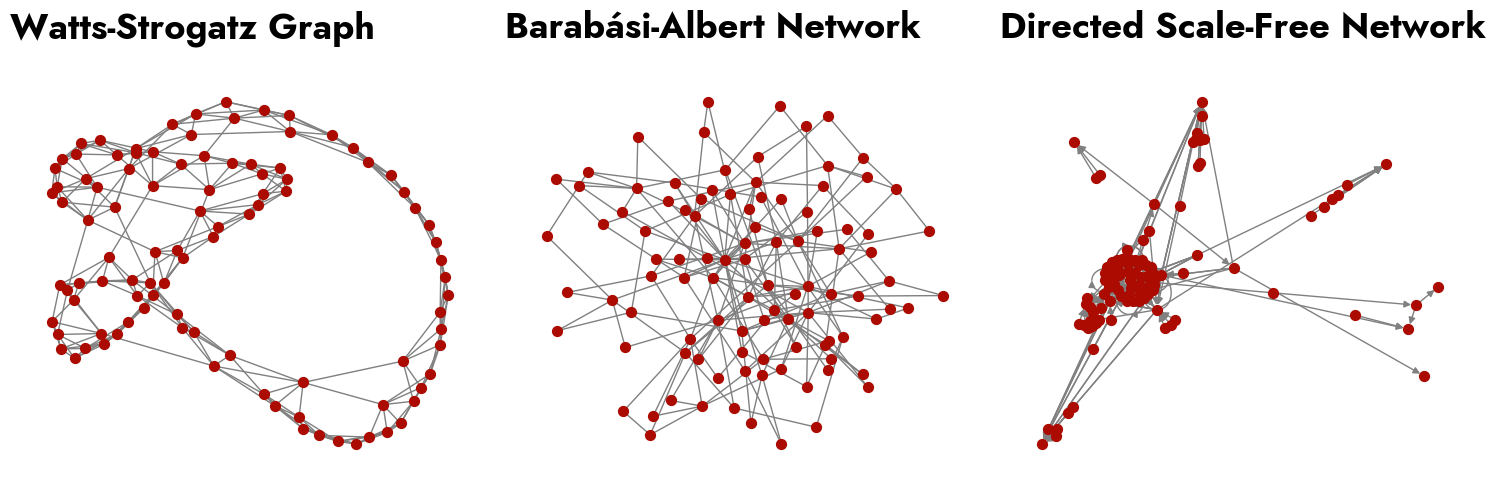

In [421]:
import matplotlib.pyplot as plt
import networkx as nx

# Set up the figure and subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# 1. Watts-Strogatz graph
ws = nx.watts_strogatz_graph(n=100, k=6, p=0.03)
pos_ws = nx.spring_layout(ws)  # Use spring layout for better appearance
nx.draw(ws, pos_ws, ax=axes[0], node_color='#ab0b00', edge_color='gray', node_size=50)
axes[0].set_title('Watts-Strogatz Graph')
axes[0].set_axis_off()  # Turn off the axis

# 2. Barabási-Albert graph
ba = nx.barabasi_albert_graph(n=100, m=2)
pos_ba = nx.spring_layout(ba)
nx.draw(ba, pos_ba, ax=axes[1], node_color='#ab0b00', edge_color='gray', node_size=50)
axes[1].set_title('Barabási-Albert Network')
axes[1].set_axis_off()

# 3. Scale-Free graph
# Generating a scale-free network using Barabási-Albert since it's inherently scale-free
sf = nx.scale_free_graph(n=100)  # Using the same as Barabási-Albert for demonstration
pos_sf = nx.spring_layout(sf)
nx.draw(sf, pos_sf, ax=axes[2], node_color='#ab0b00', edge_color='gray', node_size=50)
axes[2].set_title('Directed Scale-Free Network')
axes[2].set_axis_off()

# Show plot
plt.tight_layout()
plt.savefig(output_dir + "network_comparison.png", dpi=300, transparent=True)
plt.show()

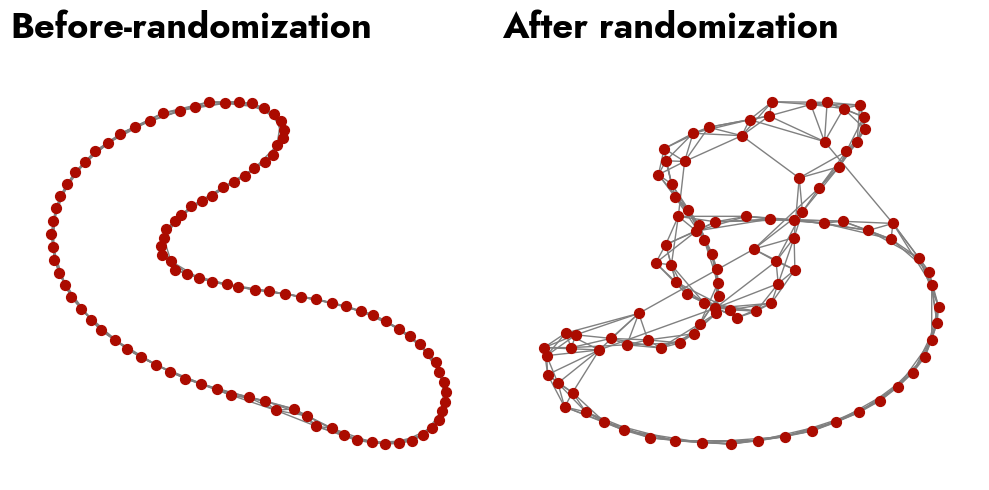

In [431]:
import matplotlib.pyplot as plt
import networkx as nx

# Set up the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # 1 row, 3 columns

# 1. Watts-Strogatz graph
ws = nx.watts_strogatz_graph(n=100, k=6, p=0.0)
pos_ws = nx.spring_layout(ws)  # Use spring layout for better appearance
nx.draw(ws, pos_ws, ax=axes[0], node_color='#ab0b00', edge_color='gray', node_size=50)
axes[0].set_title('Before-randomization')
axes[0].set_axis_off()  # Turn off the axis



sf =  nx.watts_strogatz_graph(n=100, k=6, p=0.02) # Using the same as Barabási-Albert for demonstration
pos_sf = nx.spring_layout(sf)
nx.draw(sf, pos_sf, ax=axes[1], node_color='#ab0b00', edge_color='gray', node_size=50)
axes[1].set_title('After randomization')
axes[1].set_axis_off()

# Show plot
plt.tight_layout()
plt.savefig(output_dir + "watts-strogatz-demo.png", dpi=300, transparent=True)
plt.show()

In [345]:
import powerlaw


def plot_loglog(G, filename=None):
    # Calculate degree frequency
    degree_freq = nx.degree_histogram(G)
    degrees = range(len(degree_freq))
    print(degree_freq)
    # Filter out zero frequencies to avoid issues in loglog plots and fitting
    nonzero_degrees = [degree for degree, freq in enumerate(degree_freq) if freq > 0]
    nonzero_freqs = [freq for freq in degree_freq if freq > 0]
    
    # Fit the power law model to the nonzero frequencies
    fit = powerlaw.Fit(nonzero_freqs, discrete=True, xmin=min(nonzero_degrees))
    alpha, sigma = fit.alpha, fit.sigma
    print(f"Alpha: {alpha}, Sigma: {sigma}")
    #
    # Plot the original degree distribution
    plt.figure(figsize=(8, 8))
    plt.loglog(nonzero_degrees, [d / len(G)  for d in nonzero_freqs], 'o', c='#ab0b00', alpha=.9, label='Degree distribution')
    
    # Generate and plot the power law trend line over the observed range
    print(nonzero_degrees)
    #plt.loglog(nonzero_degrees, [fit.power_law.pdf(d)  for d in nonzero_degrees], 'k-', label=f'Power law fit (α={np.round(alpha,2)})')
    
    plt.xlabel('Degree')
    plt.ylabel('Frequency of Degree')
   #plt.legend(pos,loc='upper right')
    if filename is not None:
        plt.savefig(filename, dpi=300, transparent=True)
    plt.close()
    #plt.show()



for this_rand_value in randomize_by:
    G_randomized = randomize_network_v2(G_perceptron, p_rewiring=this_rand_value)
    
    plot_loglog(G_randomized, filename = output_dir + f"perceptron_graph_randomized_p={this_rand_value}_powerlaw_fit.png")

[0, 1825, 664, 343, 157, 109, 37, 39, 48, 26, 17, 16, 13, 15, 7, 6, 15, 7, 9, 6, 13, 13, 10, 3, 4, 8, 10, 3, 8, 4, 3, 6, 3, 3, 2, 1, 4, 1, 2, 3, 1, 3, 4, 0, 1, 3, 3, 1, 3, 0, 3, 2, 0, 0, 2, 0, 0, 4, 1, 1, 1, 0, 0, 0, 0, 1, 3, 0, 0, 0, 2, 0, 0, 0, 2, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [435]:

rename_dict = {
    'n_agents': 'Number of Agents',
    'p_rewiring': 'Probability of Rewiring',
    'uncertainty': 'Uncertainty Level',
    'n_experiments': 'Number of Experiments',
    'share_of_correct_agents_at_conv': 'Share of correct agents',
    'mean_degree': 'Mean Degree',
    'ba_degree':'BA-Degree',
    'convergence_step': 'Steps until convergence (log)'

    
}


# 1. Bayes-agent Perceptron

In [451]:
data_df = pd.read_csv('bayesagent_perceptron_results_df.csv')

## Plot the share of correct agents

In [452]:

data_df['converged'] = data_df['convergence_step']< 10000
print('N. unconverged simulations: ', np.sum(~ data_df['converged']))
data_df['share_of_correct_agents_at_conv'] = data_df['true_consensus']
data_df

N. unconverged simulations:  2


n_agents  p_rewiring  uncertainty  n_experiments rewiring_type  \
0         3519    0.441173     0.016661           7427     randomize   
1         3519    0.817119     0.009739           1912     randomize   
2         3519    0.798491     0.022603           5749     randomize   
3         3519    0.384941     0.003522           5838     randomize   
4         3519    0.404991     0.024896           5526     randomize   
...        ...         ...          ...            ...           ...   
1995      3519    0.583912     0.021065           4549     randomize   
1996      3519    0.188740     0.007631           7496     randomize   
1997      3519    0.847185     0.002986            757     randomize   
1998      3519    0.145805     0.015593            352     randomize   
1999      3519    0.466978     0.003925           1815     randomize   

      mean_degree  true_consensus  convergence_step agent_type  converged  \
0        4.346689        0.773231                 6      bayes       True   
1        4.346121        0.897698                28      bayes       True   
2        4.346689        0.903666                 7      bayes       True   
3        4.345553        0.705030                55      bayes       True   
4        4.346689        0.780619                 6      bayes       True   
...           ...             ...               ...        ...        ...   
1995     4.346121        0.849957                 7      bayes       True   
1996     4.346121        0.619494                14      bayes       True   
1997     4.346121        0.874680               526      bayes       True   
1998     4.346689        0.557829                50      bayes       True   
1999     4.346689        0.729753               130      bayes       True   

      share_of_correct_agents_at_conv  
0                            0.773231  
1                            0.897698  
2                            0.903666  
3                            0.705030  
4                            0.780619  
...                               ...  
1995                         0.849957  
1996                         0.619494  
1997                         0.874680  
1998                         0.557829  
1999                         0.729753  

[2000 rows x 11 columns]

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/2656230545.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns=rename_dict, inplace=True)


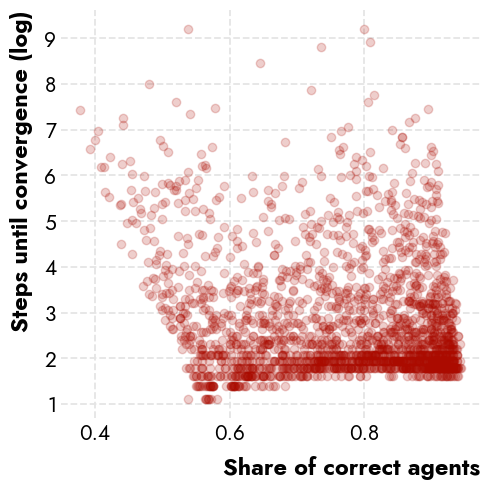

In [453]:

X = data_df[['share_of_correct_agents_at_conv'	]]
y = pd.DataFrame(np.log(data_df['convergence_step']))
X.rename(columns=rename_dict, inplace=True)
y.rename(columns=rename_dict, inplace=True)

plot_scatter_matrix(X, y, max_cols=1, filename=output_dir + 'speed_quality_tradeoff_perceptron')

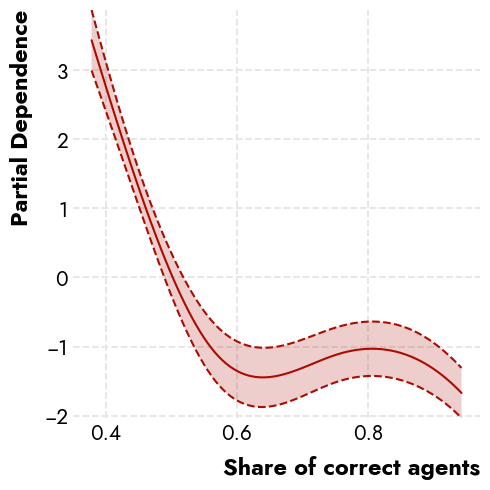

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      4.2232
Link Function:                     IdentityLink Log Likelihood:                                 -3255.8093
Number of Samples:                         1980 AIC:                                             6522.0651
                                                AICc:                                             6522.098
                                                GCV:                                                1.4773
                                                Scale:                                              1.4716
                                                Pseudo R-Squared:                                   0.1421
Feature Function                  Lam

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/3942841905.py:9: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [454]:


# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

# Fitting the Logistic GAM model
gam = LinearGAM(s(0,n_splines=6) ).fit(X_train, y_train)


plot_partial_dependence(gam,['#ab0b00']*6,X.columns,max_cols=1,filename=output_dir + f"speed_quality_tradeoff_perceptron_gam.png")
print(gam.summary())

## Predicting 'share_correct_at_convergence'


/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/3962382071.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns=rename_dict, inplace=True)


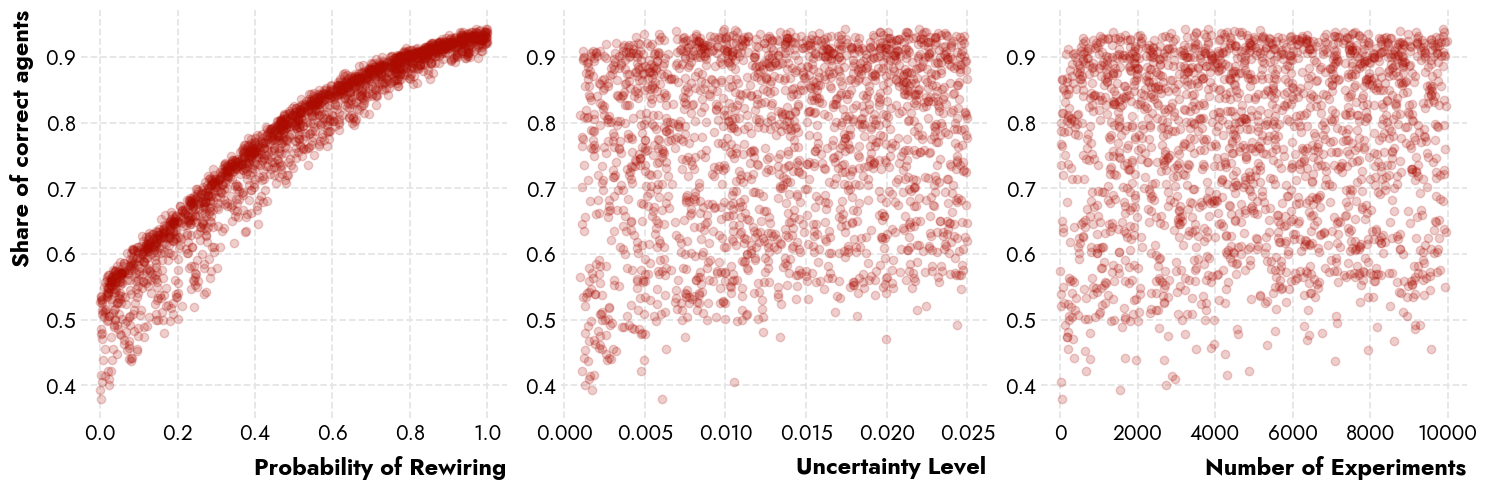

In [313]:

X = data_df[['p_rewiring',	'uncertainty',	'n_experiments'	]]
y = pd.DataFrame(data_df['share_of_correct_agents_at_conv'])
X.rename(columns=rename_dict, inplace=True)
y.rename(columns=rename_dict, inplace=True)

plot_scatter_matrix(X, y, max_cols=3, filename=output_dir + 'perceptron_bayesagent_share_at_convergence')


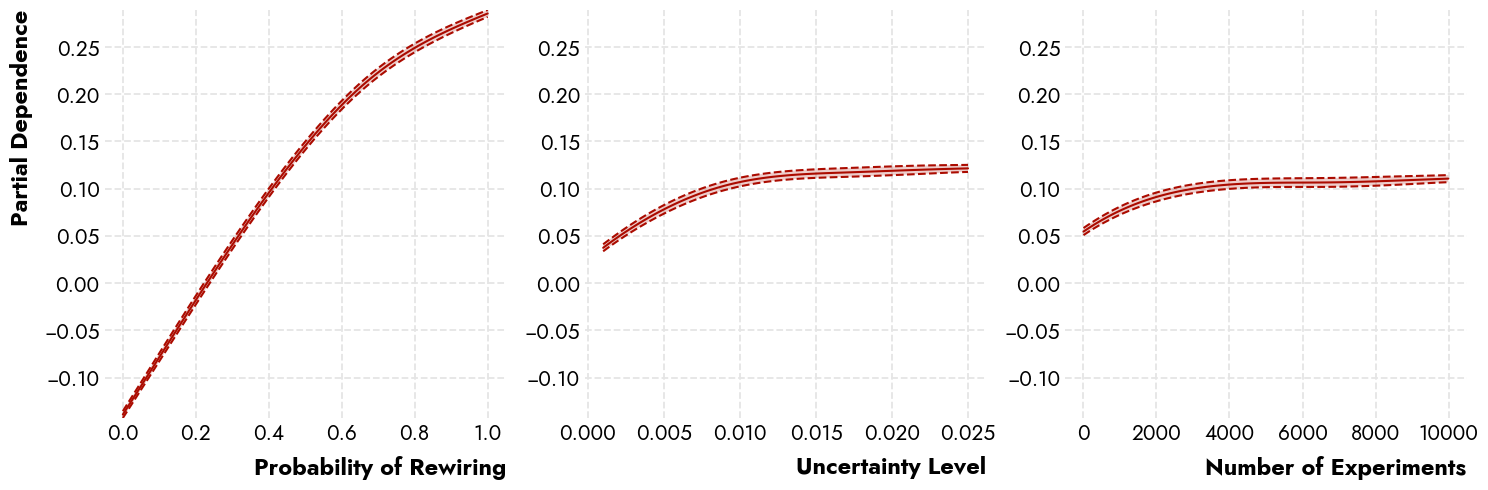

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     11.4023
Link Function:                     IdentityLink Log Likelihood:                              -3723786.7085
Number of Samples:                         1980 AIC:                                          7447598.2216
                                                AICc:                                         7447598.3906
                                                GCV:                                                0.0003
                                                Scale:                                              0.0003
                                                Pseudo R-Squared:                                   0.9852
Feature Function                  Lam

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/3818989027.py:9: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [314]:


# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

# Fitting the Logistic GAM model
gam = LinearGAM(s(0,n_splines=6) + s(1,n_splines=6) + s(2,n_splines=6)  ).fit(X_train, y_train)


plot_partial_dependence(gam,['#ab0b00']*6,X.columns,max_cols=3,filename=output_dir + f"perceptron_graph_randomized_partial_dependence_share_corr_agents.png")
print(gam.summary())

## perceptron convergence steps

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/599321239.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns=rename_dict, inplace=True)


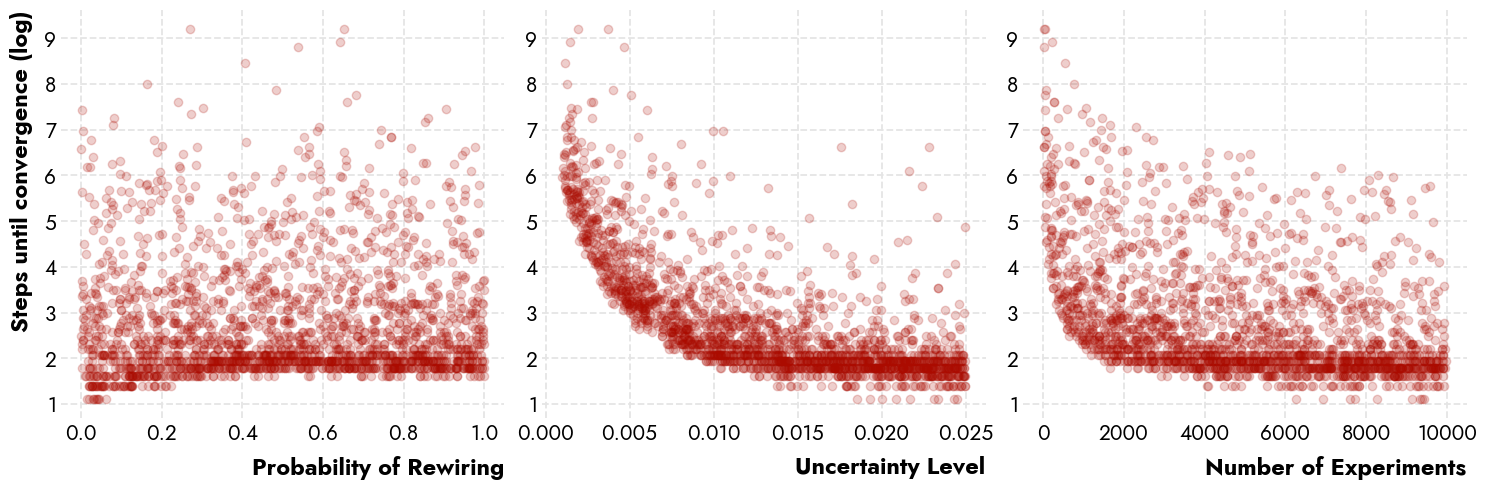

In [316]:

X = data_df[['p_rewiring',	'uncertainty',	'n_experiments'	]]
y = pd.DataFrame(np.log(data_df['convergence_step']))
X.rename(columns=rename_dict, inplace=True)
y.rename(columns=rename_dict, inplace=True)

plot_scatter_matrix(X, y, max_cols=3, filename=output_dir + 'perceptron_bayesagent_log_convergence_steps')


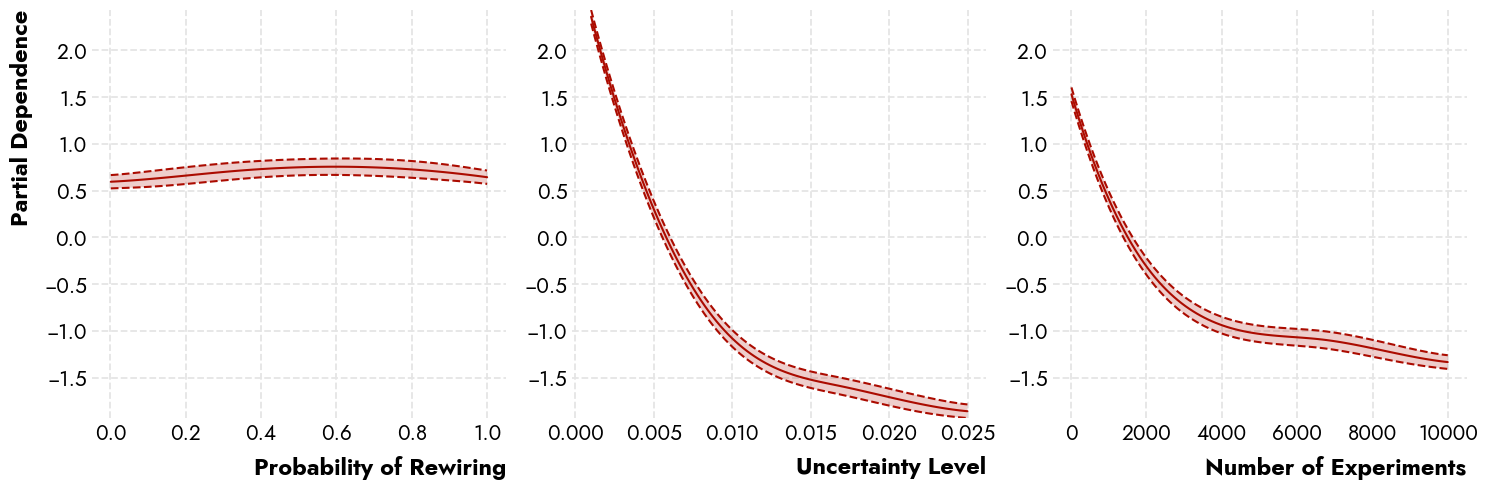

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     11.4023
Link Function:                     IdentityLink Log Likelihood:                                 -7104.7431
Number of Samples:                         1980 AIC:                                            14234.2907
                                                AICc:                                           14234.4597
                                                GCV:                                                 0.101
                                                Scale:                                                 0.1
                                                Pseudo R-Squared:                                   0.9419
Feature Function                  Lam

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/599103013.py:8: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [317]:


# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

# Fitting the Logistic GAM model
gam = LinearGAM(s(0,n_splines=6) + s(1,n_splines=6) + s(2,n_splines=6)  ).fit(X_train, y_train)

plot_partial_dependence(gam,['#ab0b00']*6,X.columns,filename=output_dir + f"perceptron_graph_randomized_partial_dependence_convergence_time_log.png")
print(gam.summary())

## Perceptron beta-agents

In [318]:
data_df = pd.read_csv('betaagent_perceptron_results_df.csv')
import dill

data_df['converged'] = data_df['convergence_step']< 10000
print('N. unconverged simulations: ', np.sum(~ data_df['converged']))
data_df['share_of_correct_agents_at_conv'] = data_df['true_consensus']
data_df

N. unconverged simulations:  0


n_agents  p_rewiring  uncertainty  n_experiments rewiring_type  \
0        3519    0.167128     0.016293           7823     randomize   
1        3519    0.336735     0.001628           5232     randomize   
2        3519    0.792060     0.020601           8277     randomize   
3        3519    0.617836     0.024003           2308     randomize   
4        3519    0.312612     0.008055           6000     randomize   
..        ...         ...          ...            ...           ...   
495      3519    0.674205     0.013683           5655     randomize   
496      3519    0.154921     0.017435           2927     randomize   
497      3519    0.827781     0.007085           2415     randomize   
498      3519    0.608561     0.007434           4547     randomize   
499      3519    0.972876     0.024025           6550     randomize   

     mean_degree  true_consensus  convergence_step agent_type  converged  \
0       4.346121        0.641091                13       beta       True   
1       4.346689        0.417164                40       beta       True   
2       4.346689        0.896562                11       beta       True   
3       4.344984        0.852231                22       beta       True   
4       4.346121        0.679170                16       beta       True   
..           ...             ...               ...        ...        ...   
495     4.346121        0.869849                15       beta       True   
496     4.346689        0.622052                22       beta       True   
497     4.346689        0.862177                22       beta       True   
498     4.346121        0.805058                16       beta       True   
499     4.346689        0.926684                12       beta       True   

     share_of_correct_agents_at_conv  
0                           0.641091  
1                           0.417164  
2                           0.896562  
3                           0.852231  
4                           0.679170  
..                               ...  
495                         0.869849  
496                         0.622052  
497                         0.862177  
498                         0.805058  
499                         0.926684  

[500 rows x 11 columns]

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/130950285.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns=rename_dict, inplace=True)


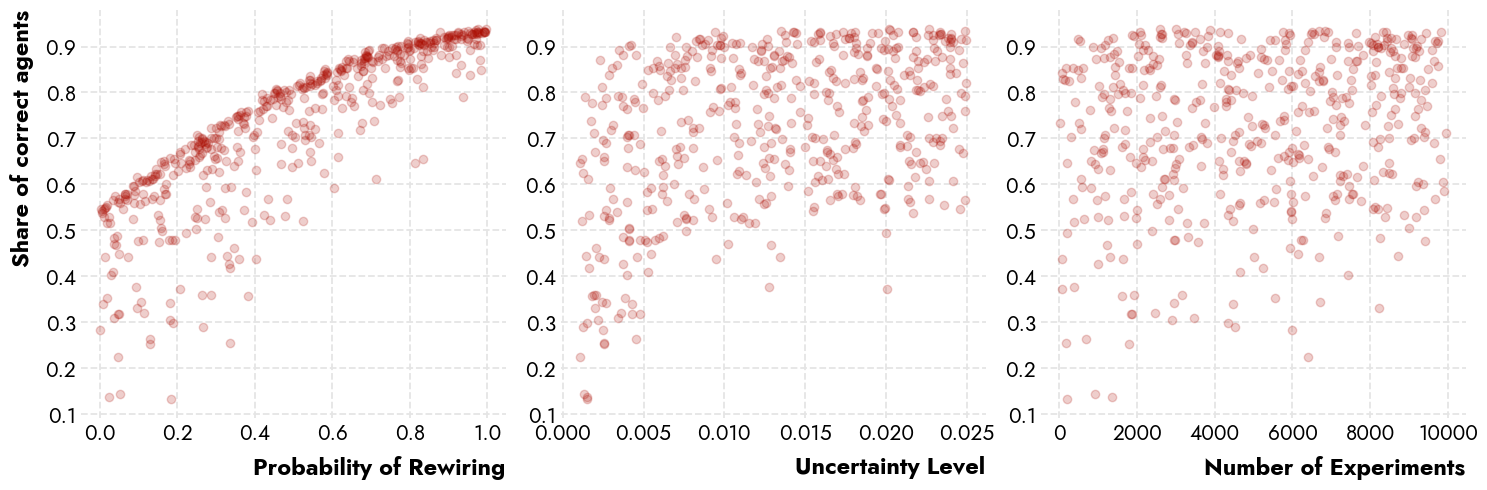

In [320]:

X = data_df[['p_rewiring',	'uncertainty',	'n_experiments'	]]
y = pd.DataFrame(data_df['share_of_correct_agents_at_conv'])
X.rename(columns=rename_dict, inplace=True)
y.rename(columns=rename_dict, inplace=True)

plot_scatter_matrix(X, y, max_cols=3, filename=output_dir + 'perceptron_betaagent_share_at_convergence')

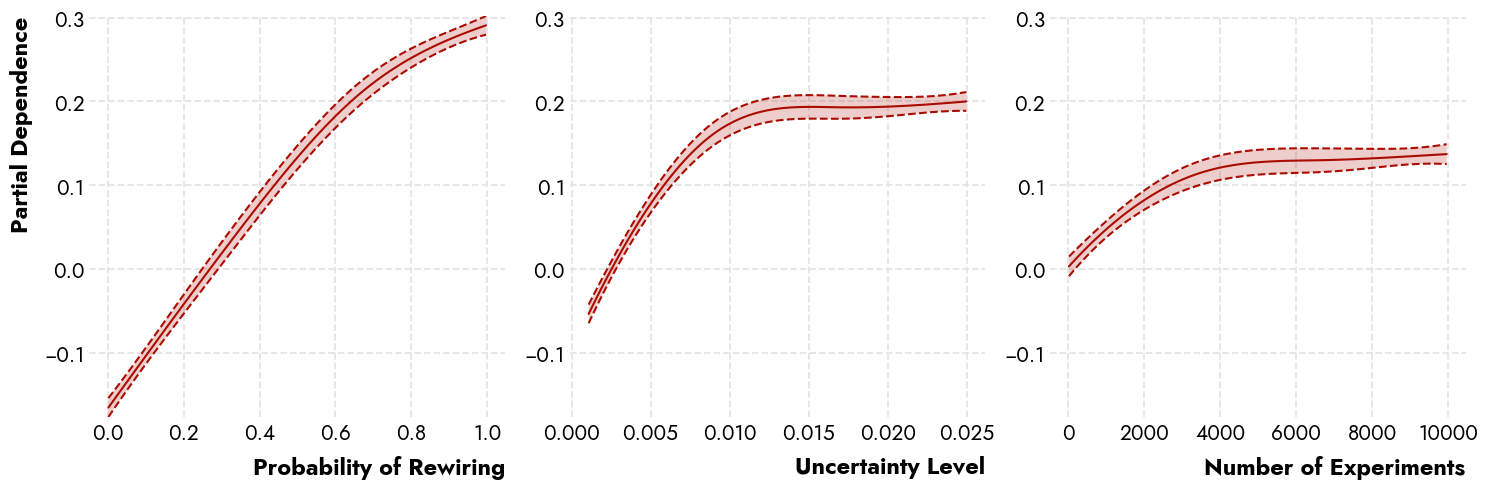

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                       9.739
Link Function:                     IdentityLink Log Likelihood:                               -169378.2157
Number of Samples:                          495 AIC:                                           338777.9094
                                                AICc:                                          338778.4312
                                                GCV:                                                0.0015
                                                Scale:                                              0.0014
                                                Pseudo R-Squared:                                   0.9513
Feature Function                  Lam

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/1198874605.py:9: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [321]:


# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

# Fitting the Logistic GAM model
gam = LinearGAM(s(0,n_splines=6) + s(1,n_splines=6) + s(2,n_splines=6)  ).fit(X_train, y_train)


plot_partial_dependence(gam,['#ab0b00']*6,X.columns,max_cols=3,filename=output_dir + f"perceptron_graph_randomized_beta_agents_partial_dependence_share_corr_agents.png")
print(gam.summary())

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/508508562.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns=rename_dict, inplace=True)


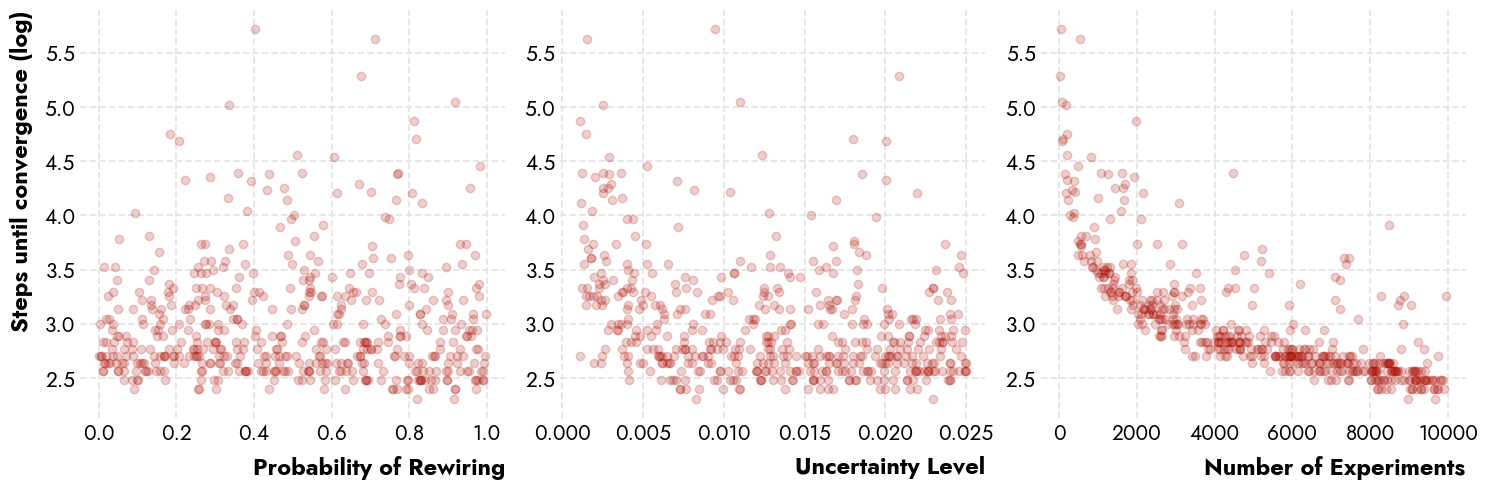

In [322]:

X = data_df[['p_rewiring',	'uncertainty',	'n_experiments'	]]
y = pd.DataFrame(np.log(data_df['convergence_step']))
X.rename(columns=rename_dict, inplace=True)
y.rename(columns=rename_dict, inplace=True)

plot_scatter_matrix(X, y, max_cols=3, filename=output_dir + 'perceptron_betaagent_log_convergence_steps')

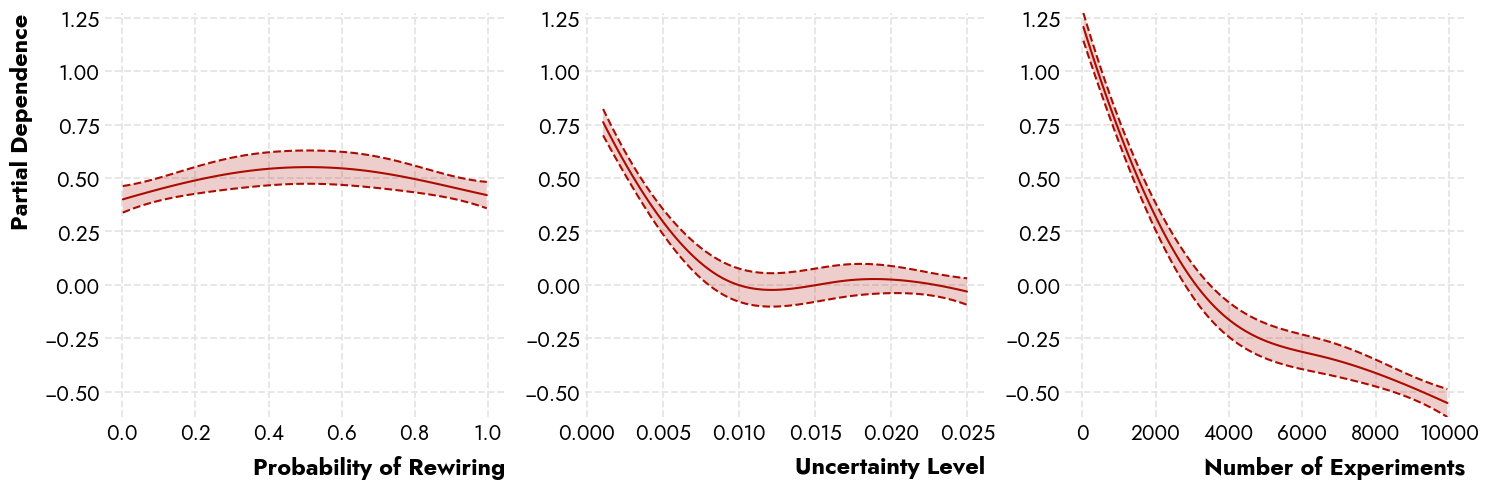

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                       9.739
Link Function:                     IdentityLink Log Likelihood:                                  -4526.124
Number of Samples:                          495 AIC:                                             9073.7261
                                                AICc:                                            9074.2478
                                                GCV:                                                0.0447
                                                Scale:                                              0.0431
                                                Pseudo R-Squared:                                   0.8574
Feature Function                  Lam

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/1585181987.py:8: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [323]:


# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

# Fitting the Logistic GAM model
gam = LinearGAM(s(0,n_splines=6) + s(1,n_splines=6) + s(2,n_splines=6)  ).fit(X_train, y_train)

plot_partial_dependence(gam,['#ab0b00']*6,X.columns,filename=output_dir + f"perceptron_graph_randomized_betaagent_partial_dependence_convergence_time_log.png")
print(gam.summary())

# Peptic Ulcer

In [325]:
data_df = pd.read_csv('bayesagent_pepticulcer_results_df.csv')

data_df['converged'] = data_df['convergence_step']< 10000
print('N. unconverged simulations: ', np.sum(~ data_df['converged']))
data_df['share_of_correct_agents_at_conv'] = data_df['true_consensus']
data_df

N. unconverged simulations:  0


n_agents  p_rewiring  uncertainty  n_experiments rewiring_type  \
0      133403    0.115123     0.010466            333     randomize   
1      133403    0.272545     0.013262           8844     randomize   
2      133403    0.743699     0.006254           6709     randomize   
3      133403    0.821127     0.013330           6909     randomize   
4      133403    0.057783     0.004422           1280     randomize   
..        ...         ...          ...            ...           ...   
495    133403    0.225546     0.004513           2532     randomize   
496    133403    0.823972     0.005324           3172     randomize   
497    133403    0.124039     0.009339           4894     randomize   
498    133403    0.187068     0.019506           9889     randomize   
499    133403    0.426025     0.003774           3616     randomize   

     mean_degree  true_consensus  convergence_step agent_type  converged  \
0      11.769600        0.671064               159      bayes       True   
1      11.769510        0.900227                 9      bayes       True   
2      11.769585        0.993808                20      bayes       True   
3      11.769585        0.996454                 6      bayes       True   
4      11.769630        0.564732               205      bayes       True   
..           ...             ...               ...        ...        ...   
495    11.769540        0.830828               126      bayes       True   
496    11.769540        0.995877                37      bayes       True   
497    11.769600        0.744286                14      bayes       True   
498    11.769570        0.834921                 7      bayes       True   
499    11.769540        0.952167                88      bayes       True   

     share_of_correct_agents_at_conv  
0                           0.671064  
1                           0.900227  
2                           0.993808  
3                           0.996454  
4                           0.564732  
..                               ...  
495                         0.830828  
496                         0.995877  
497                         0.744286  
498                         0.834921  
499                         0.952167  

[500 rows x 11 columns]

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/3623903380.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns=rename_dict, inplace=True)


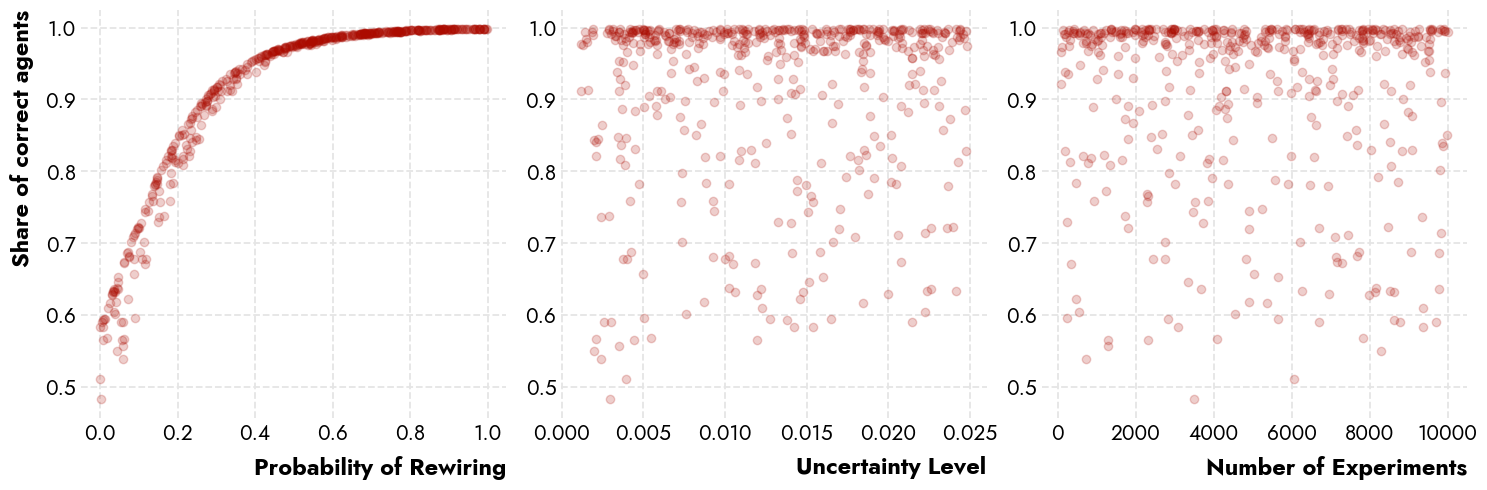

In [326]:

X = data_df[['p_rewiring',	'uncertainty',	'n_experiments'	]]
y = pd.DataFrame(data_df['share_of_correct_agents_at_conv'])
X.rename(columns=rename_dict, inplace=True)
y.rename(columns=rename_dict, inplace=True)

plot_scatter_matrix(X, y, max_cols=3, filename=output_dir + 'peptic_ulcer_bayesagent_share_at_convergence')


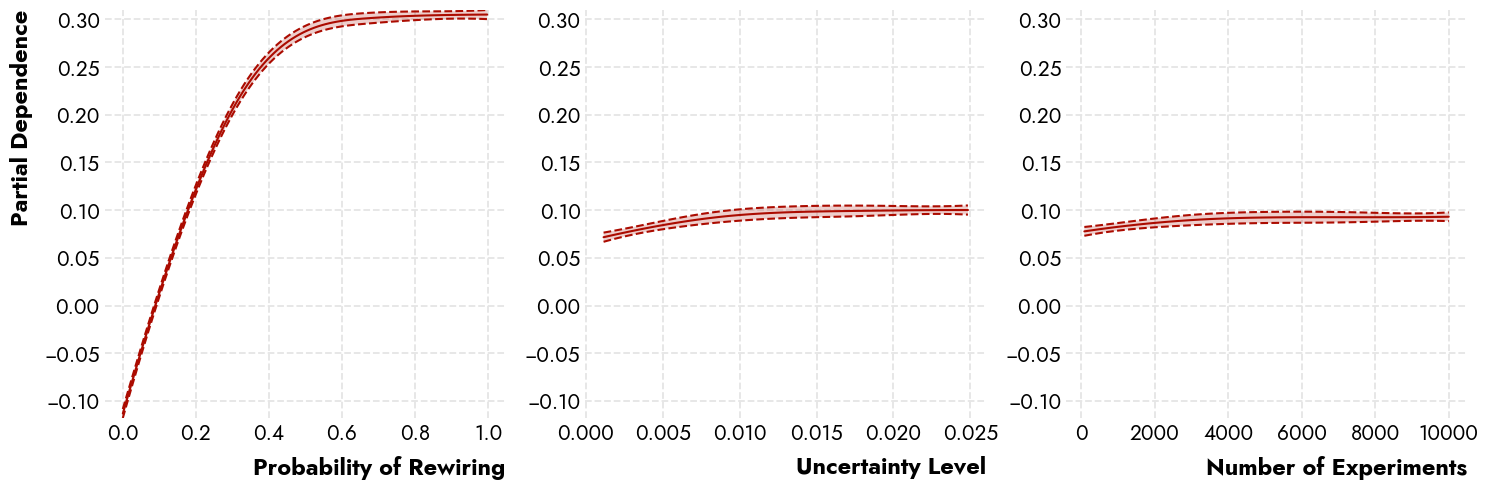

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      9.7104
Link Function:                     IdentityLink Log Likelihood:                              -1039690.0844
Number of Samples:                          495 AIC:                                          2079401.5896
                                                AICc:                                         2079402.1087
                                                GCV:                                                0.0002
                                                Scale:                                              0.0002
                                                Pseudo R-Squared:                                   0.9842
Feature Function                  Lam

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/3775527647.py:9: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [327]:
# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

# Fitting the Logistic GAM model
gam = LinearGAM(s(0,n_splines=6) + s(1,n_splines=6) + s(2,n_splines=6)  ).fit(X_train, y_train)


plot_partial_dependence(gam,['#ab0b00']*6,X.columns,max_cols=3,filename=output_dir + f"peptic_ulcer_graph_randomized_partial_dependence_share_corr_agents.png")
print(gam.summary())
## perceptron convergence steps


/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/15063490.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns=rename_dict, inplace=True)


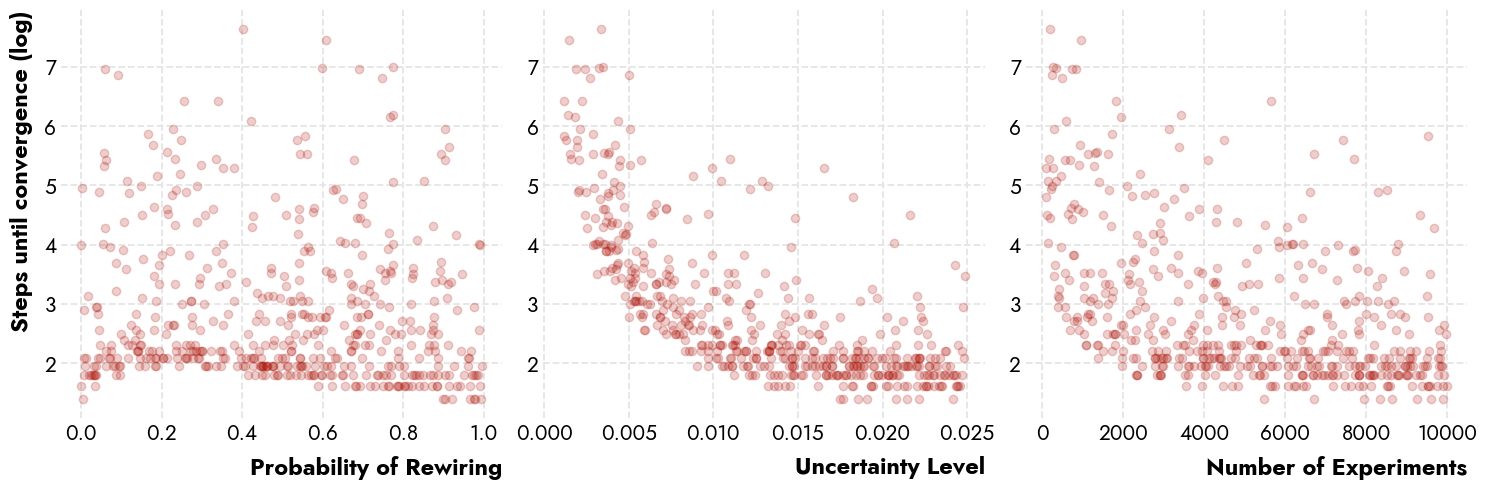

In [328]:
X = data_df[['p_rewiring',	'uncertainty',	'n_experiments'	]]
y = pd.DataFrame(np.log(data_df['convergence_step']))
X.rename(columns=rename_dict, inplace=True)
y.rename(columns=rename_dict, inplace=True)

plot_scatter_matrix(X, y, max_cols=3, filename=output_dir + 'peptic_ulcer_bayesagent_log_convergence_steps')


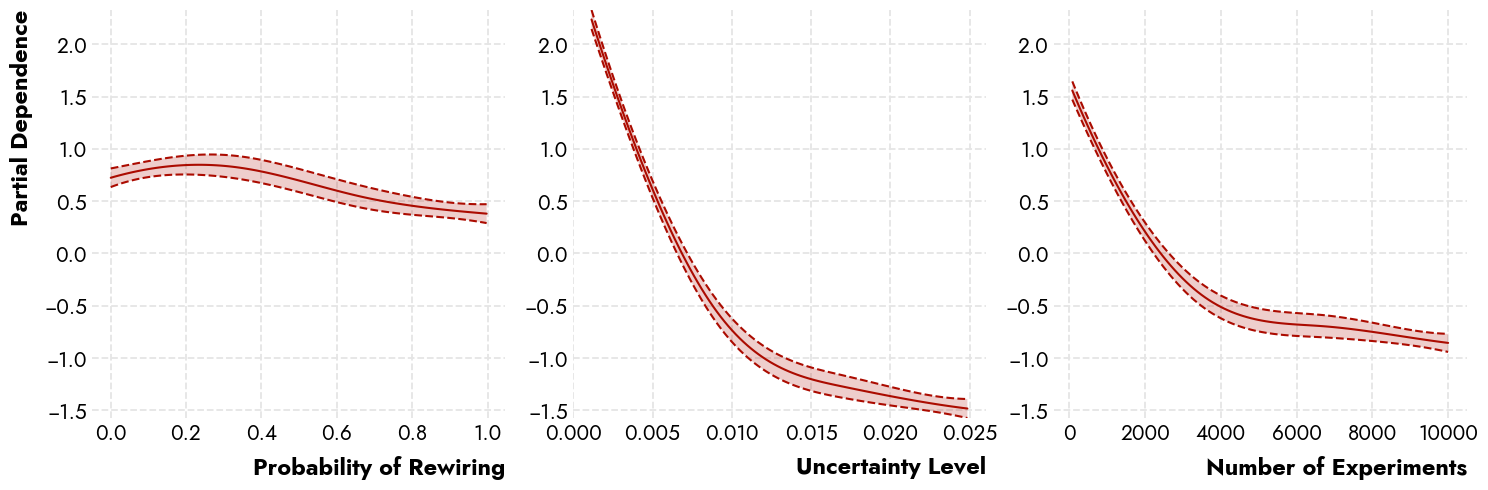

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      9.7104
Link Function:                     IdentityLink Log Likelihood:                                 -2149.6773
Number of Samples:                          495 AIC:                                             4320.7755
                                                AICc:                                            4321.2945
                                                GCV:                                                0.0859
                                                Scale:                                              0.0829
                                                Pseudo R-Squared:                                   0.9481
Feature Function                  Lam

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/100255367.py:8: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [329]:

# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

# Fitting the Logistic GAM model
gam = LinearGAM(s(0,n_splines=6) + s(1,n_splines=6) + s(2,n_splines=6)  ).fit(X_train, y_train)

plot_partial_dependence(gam,['#ab0b00']*6,X.columns,filename=output_dir + f"peptic_ulcer_graph_randomized_partial_dependence_convergence_time_log.png")
print(gam.summary())

## Peptic Ulcer beta-agents

In [331]:

data_df = pd.read_csv('betaagent_pepticulcer_results_df.csv')
import dill

data_df['converged'] = data_df['convergence_step']< 10000
print('N. unconverged simulations: ', np.sum(~ data_df['converged']))
data_df['share_of_correct_agents_at_conv'] = data_df['true_consensus']
data_df

N. unconverged simulations:  0


n_agents  p_rewiring  uncertainty  n_experiments rewiring_type  \
0      133403    0.013883     0.002264           6239     randomize   
1      133403    0.877716     0.009659           2799     randomize   
2      133403    0.762342     0.013270           4544     randomize   
3      133403    0.427151     0.007568           9316     randomize   
4      133403    0.813371     0.022454           9467     randomize   
..        ...         ...          ...            ...           ...   
495    133403    0.471281     0.020398           4223     randomize   
496    133403    0.847887     0.015319           1171     randomize   
497    133403    0.224520     0.008363           7709     randomize   
498    133403    0.154331     0.014133           3490     randomize   
499    133403    0.792849     0.002586             53     randomize   

     mean_degree  true_consensus  convergence_step agent_type  converged  \
0      11.769645        0.352263                22       beta       True   
1      11.769600        0.997069                18       beta       True   
2      11.769585        0.994693                15       beta       True   
3      11.769540        0.959828                14       beta       True   
4      11.769570        0.996477                12       beta       True   
..           ...             ...               ...        ...        ...   
495    11.769495        0.971327                20       beta       True   
496    11.769600        0.996447                29       beta       True   
497    11.769570        0.853287                18       beta       True   
498    11.769540        0.786489                21       beta       True   
499    11.769600        0.951965               676       beta       True   

     share_of_correct_agents_at_conv  
0                           0.352263  
1                           0.997069  
2                           0.994693  
3                           0.959828  
4                           0.996477  
..                               ...  
495                         0.971327  
496                         0.996447  
497                         0.853287  
498                         0.786489  
499                         0.951965  

[500 rows x 11 columns]

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/3748917411.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns=rename_dict, inplace=True)


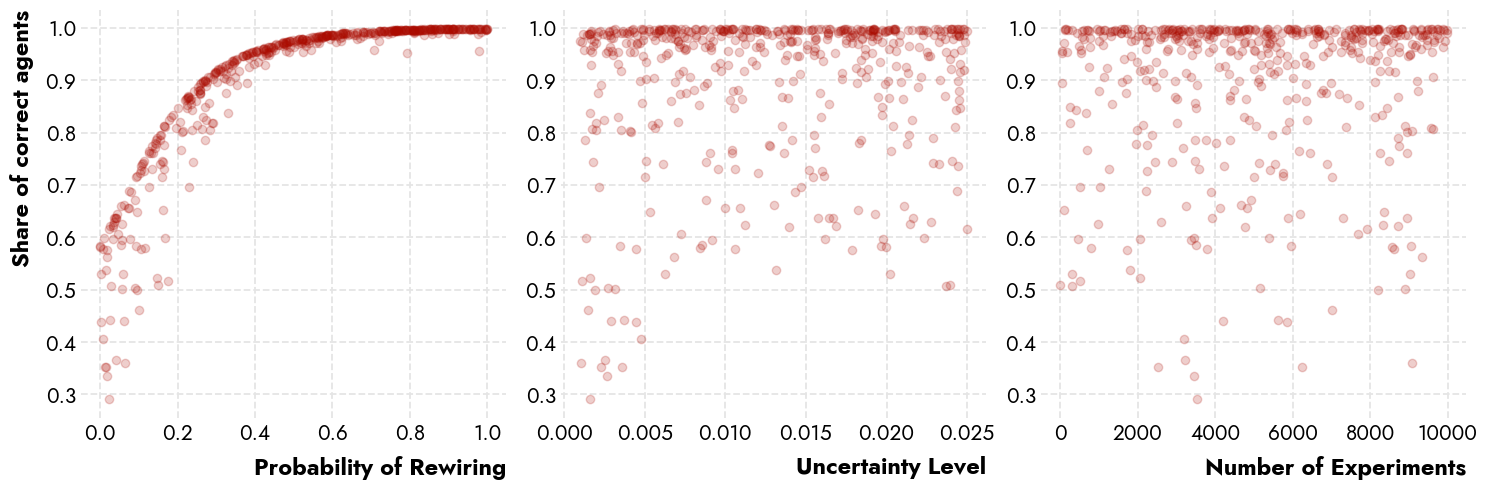

In [332]:

X = data_df[['p_rewiring',	'uncertainty',	'n_experiments'	]]
y = pd.DataFrame(data_df['share_of_correct_agents_at_conv'])
X.rename(columns=rename_dict, inplace=True)
y.rename(columns=rename_dict, inplace=True)

plot_scatter_matrix(X, y, max_cols=3, filename=output_dir + 'peptic_ulcer_betaagent_share_at_convergence')


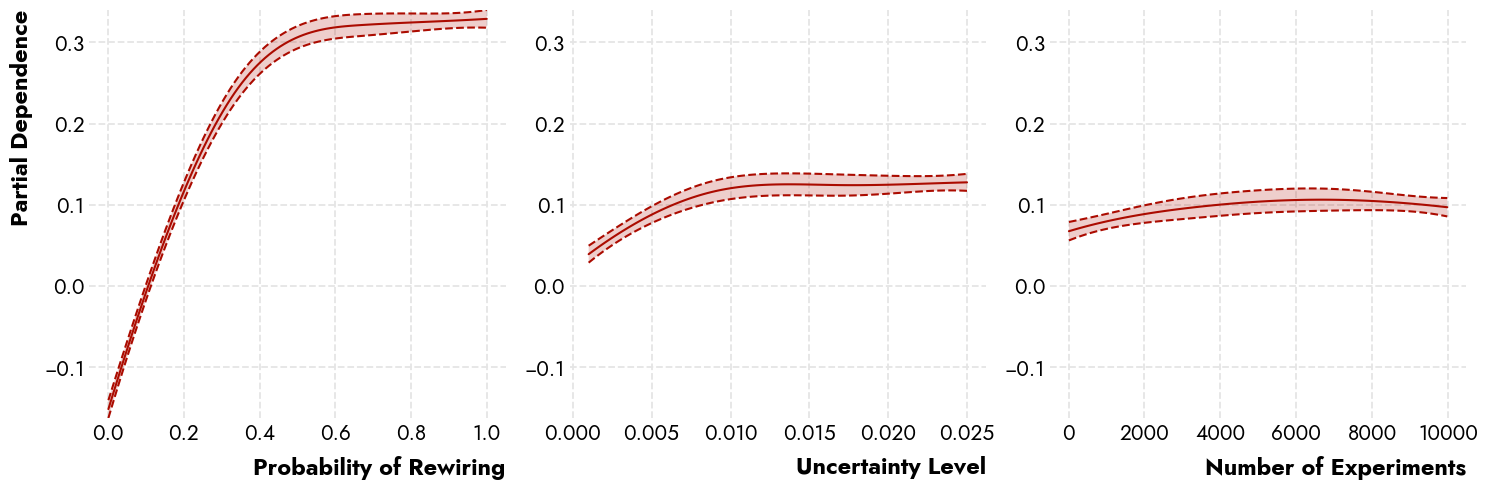

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      9.7565
Link Function:                     IdentityLink Log Likelihood:                               -183448.1218
Number of Samples:                          495 AIC:                                           366917.7567
                                                AICc:                                          366918.2801
                                                GCV:                                                0.0014
                                                Scale:                                              0.0013
                                                Pseudo R-Squared:                                   0.9394
Feature Function                  Lam

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/715918241.py:9: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [333]:

# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

# Fitting the Logistic GAM model
gam = LinearGAM(s(0,n_splines=6) + s(1,n_splines=6) + s(2,n_splines=6)  ).fit(X_train, y_train)


plot_partial_dependence(gam,['#ab0b00']*6,X.columns,max_cols=3,filename=output_dir + f"peptic_ulcer_graph_randomized_beta_agents_partial_dependence_share_corr_agents.png")
print(gam.summary())

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/161483058.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.rename(columns=rename_dict, inplace=True)


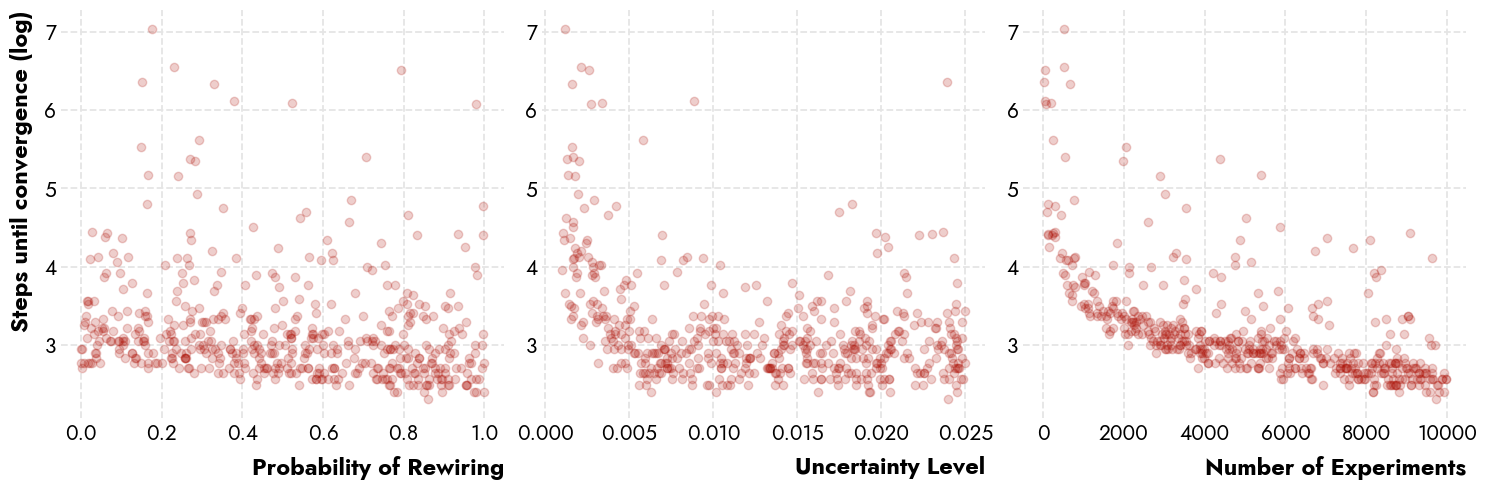

In [334]:

X = data_df[['p_rewiring',	'uncertainty',	'n_experiments'	]]
y = pd.DataFrame(np.log(data_df['convergence_step']))
X.rename(columns=rename_dict, inplace=True)
y.rename(columns=rename_dict, inplace=True)

plot_scatter_matrix(X, y, max_cols=3, filename=output_dir + 'peptic_ulcer_betaagent_log_convergence_steps')


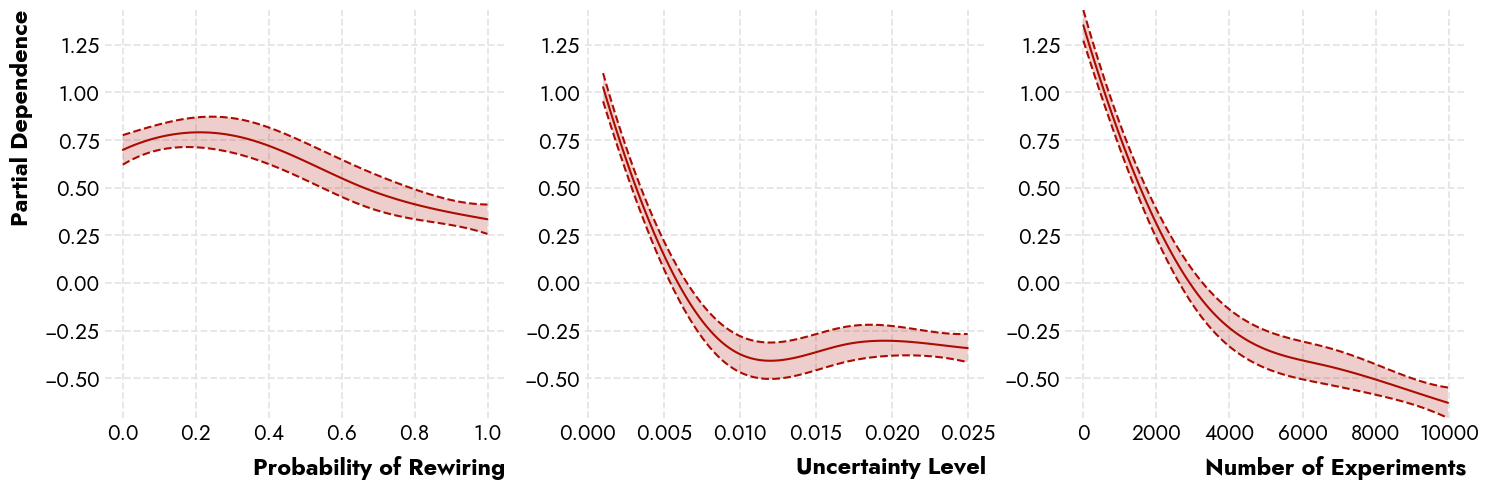

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      9.7565
Link Function:                     IdentityLink Log Likelihood:                                 -2828.4655
Number of Samples:                          495 AIC:                                             5678.4441
                                                AICc:                                            5678.9675
                                                GCV:                                                0.0675
                                                Scale:                                              0.0651
                                                Pseudo R-Squared:                                   0.8659
Feature Function                  Lam

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/3608067540.py:8: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [335]:





# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

# Fitting the Logistic GAM model
gam = LinearGAM(s(0,n_splines=6) + s(1,n_splines=6) + s(2,n_splines=6)  ).fit(X_train, y_train)

plot_partial_dependence(gam,['#ab0b00']*6,X.columns,filename=output_dir + f"peptic_ulcer_graph_randomized_betaagent_partial_dependence_convergence_time_log.png")
print(gam.summary())


# Bayes-agent-results (Simulation)


In [436]:
data_df = pd.read_csv('bayesagent_results_df.csv')
import dill

In [437]:

data_df['converged'] = data_df['convergence_step']< 10000
print('N. unconverged simulations: ', np.sum(~ data_df['converged']))
data_df['share_of_correct_agents_at_conv'] = data_df['true_consensus']
data_df

N. unconverged simulations:  155


n_agents  ba_degree   er_prob  p_rewiring  uncertainty  n_experiments  \
0           50          3  0.001581    0.314585     0.009161             88   
1          115          6  0.104298    0.934059     0.002747             94   
2           76          5  0.223489    0.998311     0.002316             35   
3           58          3  0.203830    0.041382     0.009668             70   
4          132          2  0.144579    0.650044     0.003101             31   
...        ...        ...       ...         ...          ...            ...   
2995        65          8  0.166648    0.831336     0.001522             61   
2996        22          8  0.236724    0.631580     0.004028             30   
2997       145          4  0.160007    0.177034     0.009306             61   
2998       104          3  0.182446    0.119717     0.001778             16   
2999       138         10  0.195269    0.049671     0.004923             54   

     rewiring_type  mean_degree network_type  true_consensus  \
0        randomize     5.480000           ba        1.000000   
1        randomize    10.973913           ba        1.000000   
2        randomize     9.052632           ba        1.000000   
3        randomize     5.689655           ba        1.000000   
4        randomize     3.909091           ba        0.977273   
...            ...          ...          ...             ...   
2995     randomize     8.000000           ws        1.000000   
2996     randomize     8.000000           ws        1.000000   
2997     randomize     4.000000           ws        1.000000   
2998     randomize     2.000000           ws        0.903846   
2999     randomize    10.000000           ws        1.000000   

      convergence_step agent_type  converged  share_of_correct_agents_at_conv  
0                  123      bayes       True                         1.000000  
1                  574      bayes       True                         1.000000  
2                 1873      bayes       True                         1.000000  
3                  129      bayes       True                         1.000000  
4                 3863      bayes       True                         0.977273  
...                ...        ...        ...                              ...  
2995              2666      bayes       True                         1.000000  
2996               400      bayes       True                         1.000000  
2997               167      bayes       True                         1.000000  
2998             10000      bayes      False                         0.903846  
2999               398      bayes       True                         1.000000  

[3000 rows x 14 columns]

<Axes: xlabel='convergence_step', ylabel='Count'>

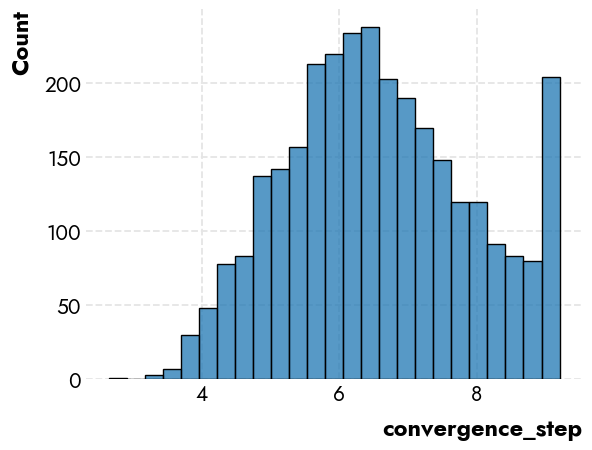

In [438]:
import seaborn as sns

sns.histplot(np.log(data_df['convergence_step']))
#"true_consensus", "choice_consensus" and "convergence_step"


In [439]:
# 

### Barabasi-Albert-graph

(0.95, 1.0)

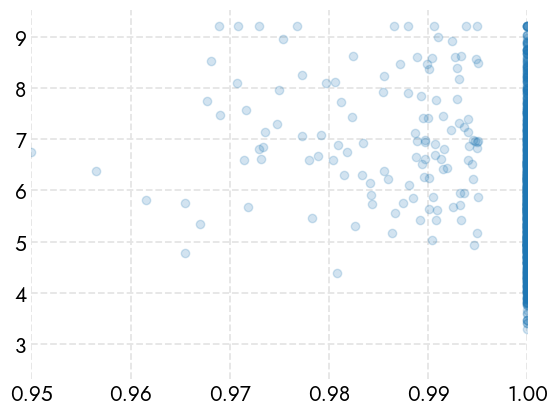

In [440]:
plt.scatter(data_df['share_of_correct_agents_at_conv'][data_df['network_type']=='ba'],
            np.log(data_df['convergence_step'][data_df['network_type']=='ba']),alpha=.2)
plt.xlim((.95,1))

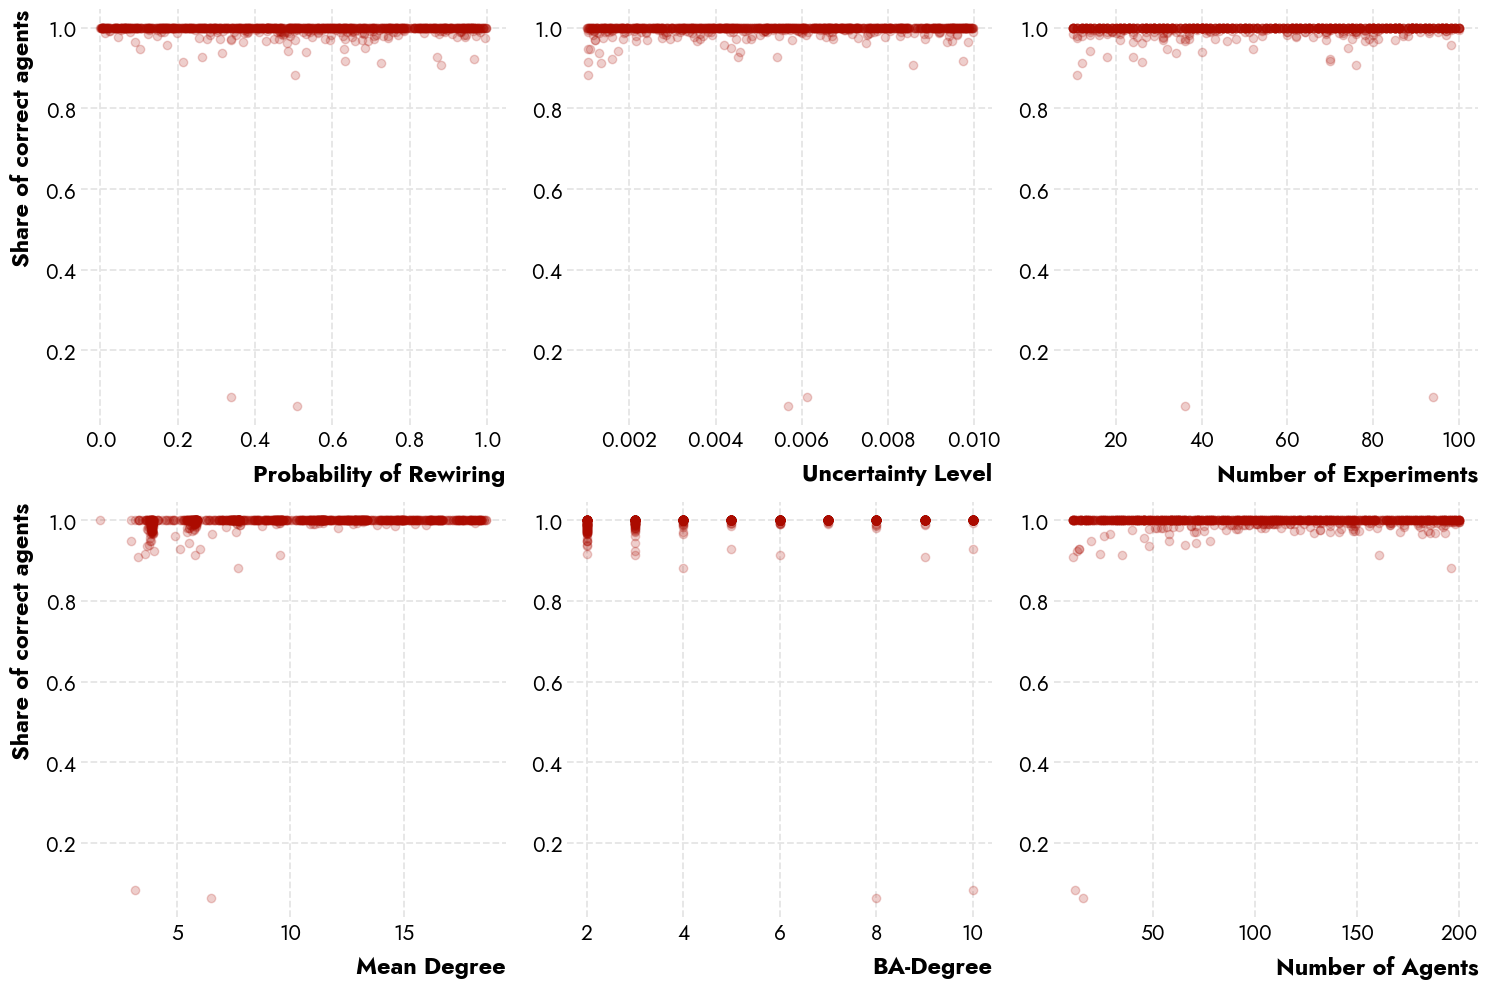

In [441]:



    # Preparing the data
X = data_df[['p_rewiring',	'uncertainty',	'n_experiments', 'mean_degree','ba_degree','n_agents']][data_df['network_type']=='ba']
y = pd.DataFrame(data_df['share_of_correct_agents_at_conv'][data_df['network_type']=='ba'])


X.rename(columns=rename_dict, inplace=True)
y.rename(columns=rename_dict, inplace=True)

plot_scatter_matrix(X, y, max_cols=3, filename=output_dir + 'bayes_agent_BA_graph_dat.png')







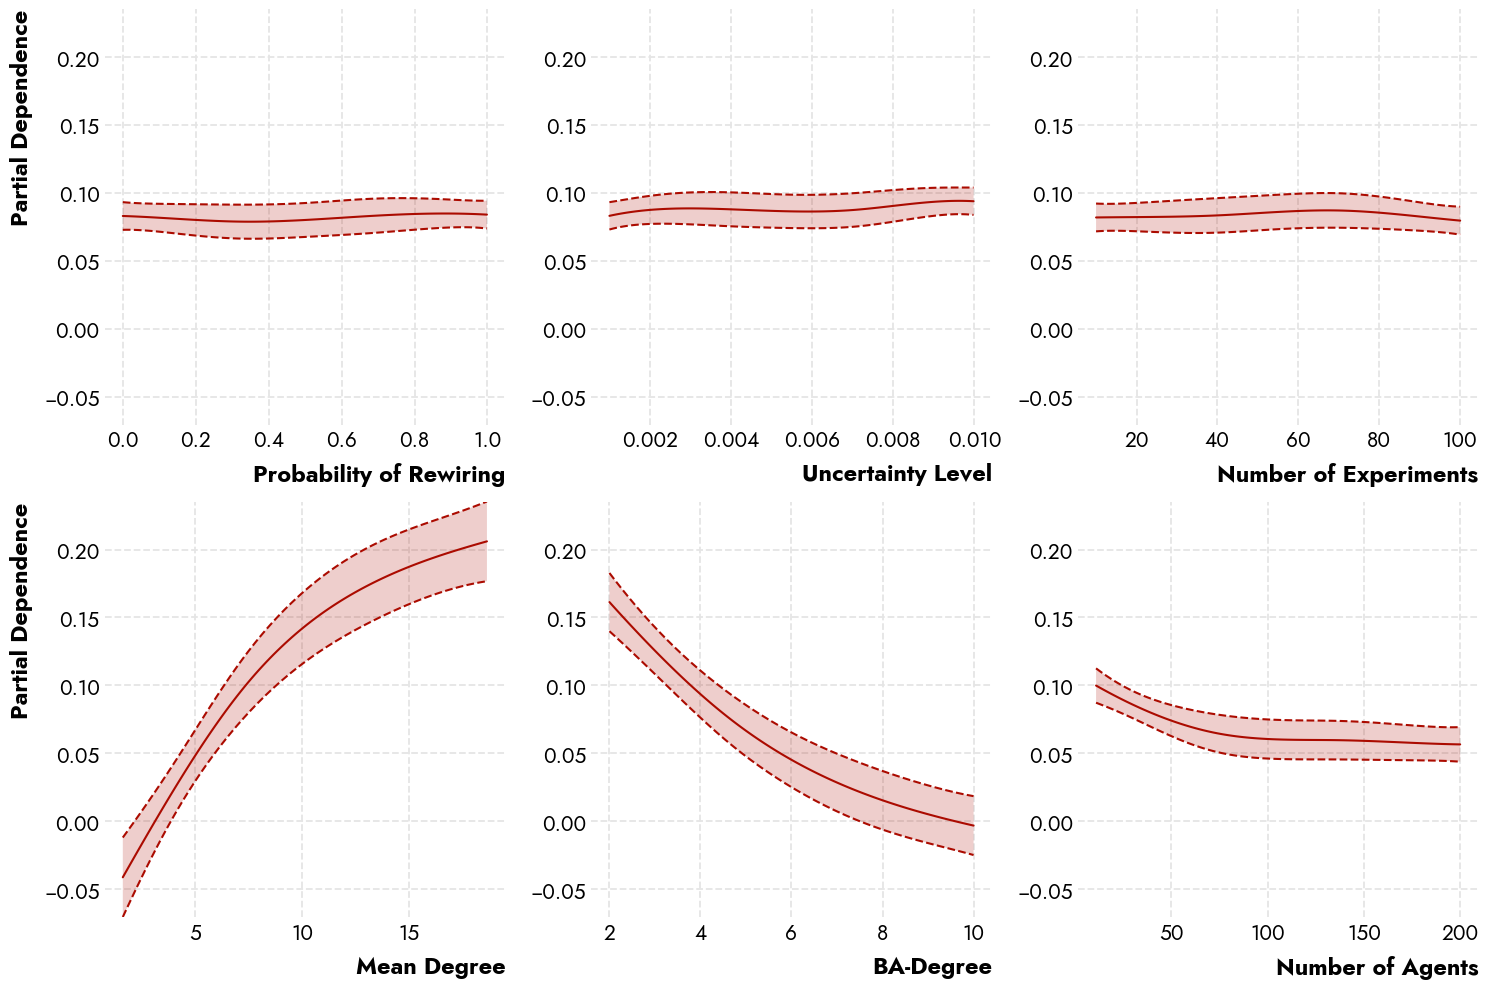

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     19.5321
Link Function:                     IdentityLink Log Likelihood:                               -298574.6004
Number of Samples:                          990 AIC:                                            597190.265
                                                AICc:                                           597191.178
                                                GCV:                                                0.0017
                                                Scale:                                              0.0016
                                                Pseudo R-Squared:                                    0.145
Feature Function                  Lam

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/3499174533.py:8: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [442]:



# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

# Fitting the Logistic GAM model
gam = LinearGAM(s(0,n_splines=6) + s(1,n_splines=6) + s(2,n_splines=6)+ s(3,n_splines=6)+ s(4,n_splines=6)+ s(5,n_splines=6)  ).fit(X_train, y_train)

plot_partial_dependence(gam,['#ab0b00']*6,X.columns,filename=output_dir + f"bayes_agent_BA_graph_gam.png")
print(gam.summary())


#### convergence steps

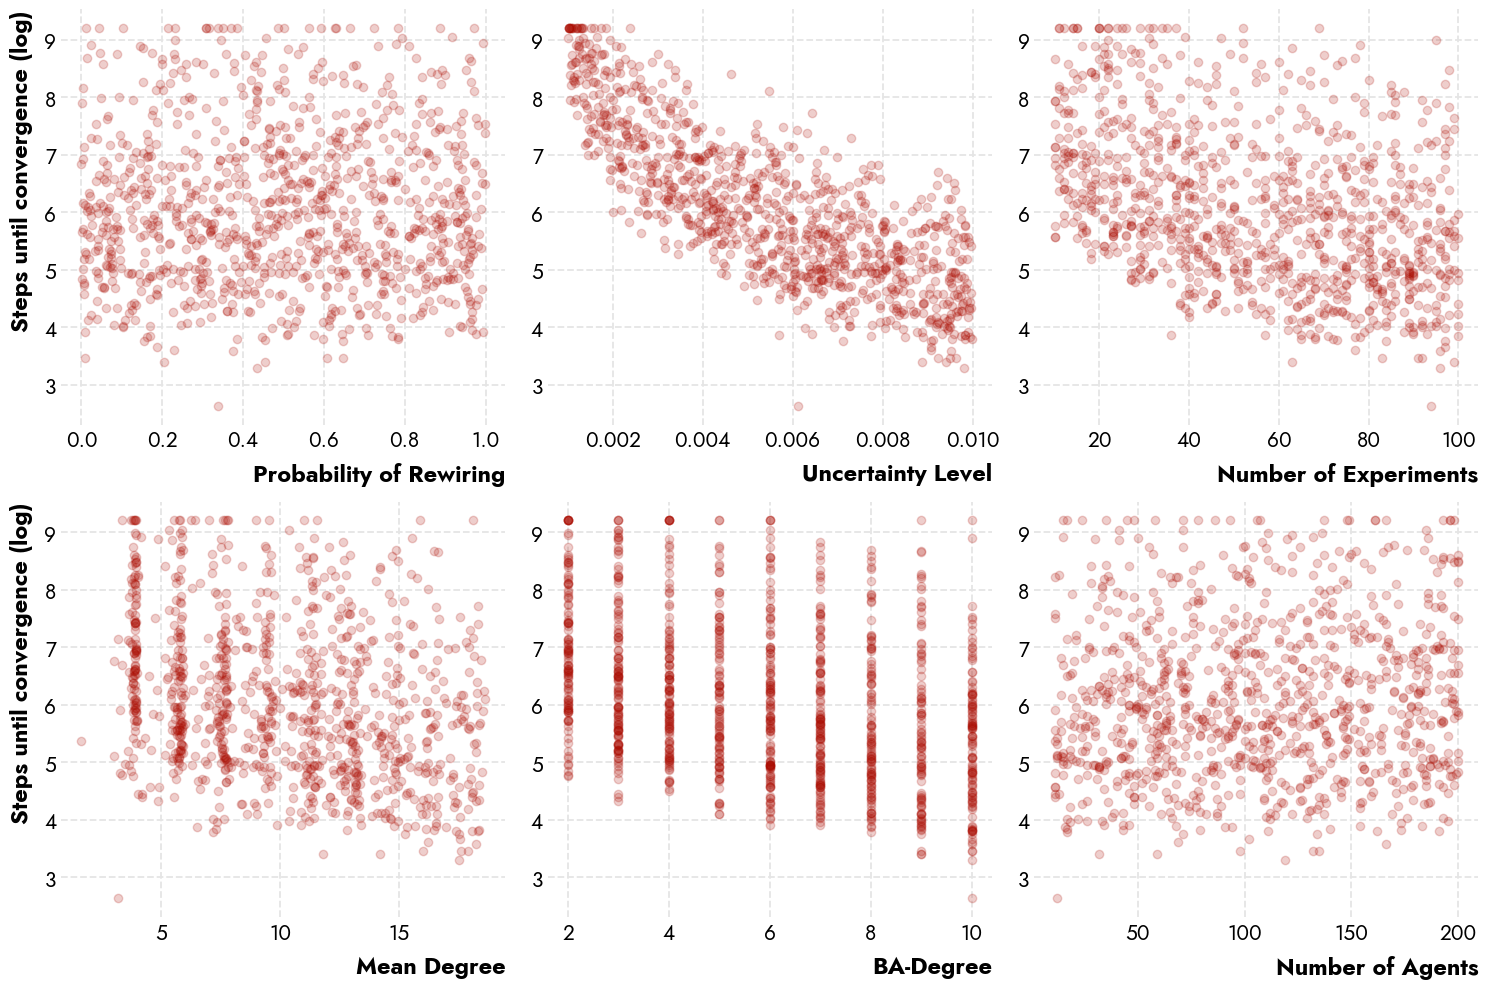

In [444]:

    # Preparing the data
X = data_df[['p_rewiring',	'uncertainty',	'n_experiments', 'mean_degree','ba_degree','n_agents']][data_df['network_type']=='ba']
y =  pd.DataFrame(np.log(data_df['convergence_step'][data_df['network_type']=='ba']))

X.rename(columns=rename_dict, inplace=True)
y.rename(columns=rename_dict, inplace=True)

plot_scatter_matrix(X, y, max_cols=3, filename=output_dir + 'bayes_agent_BA_graph_convergence.png')



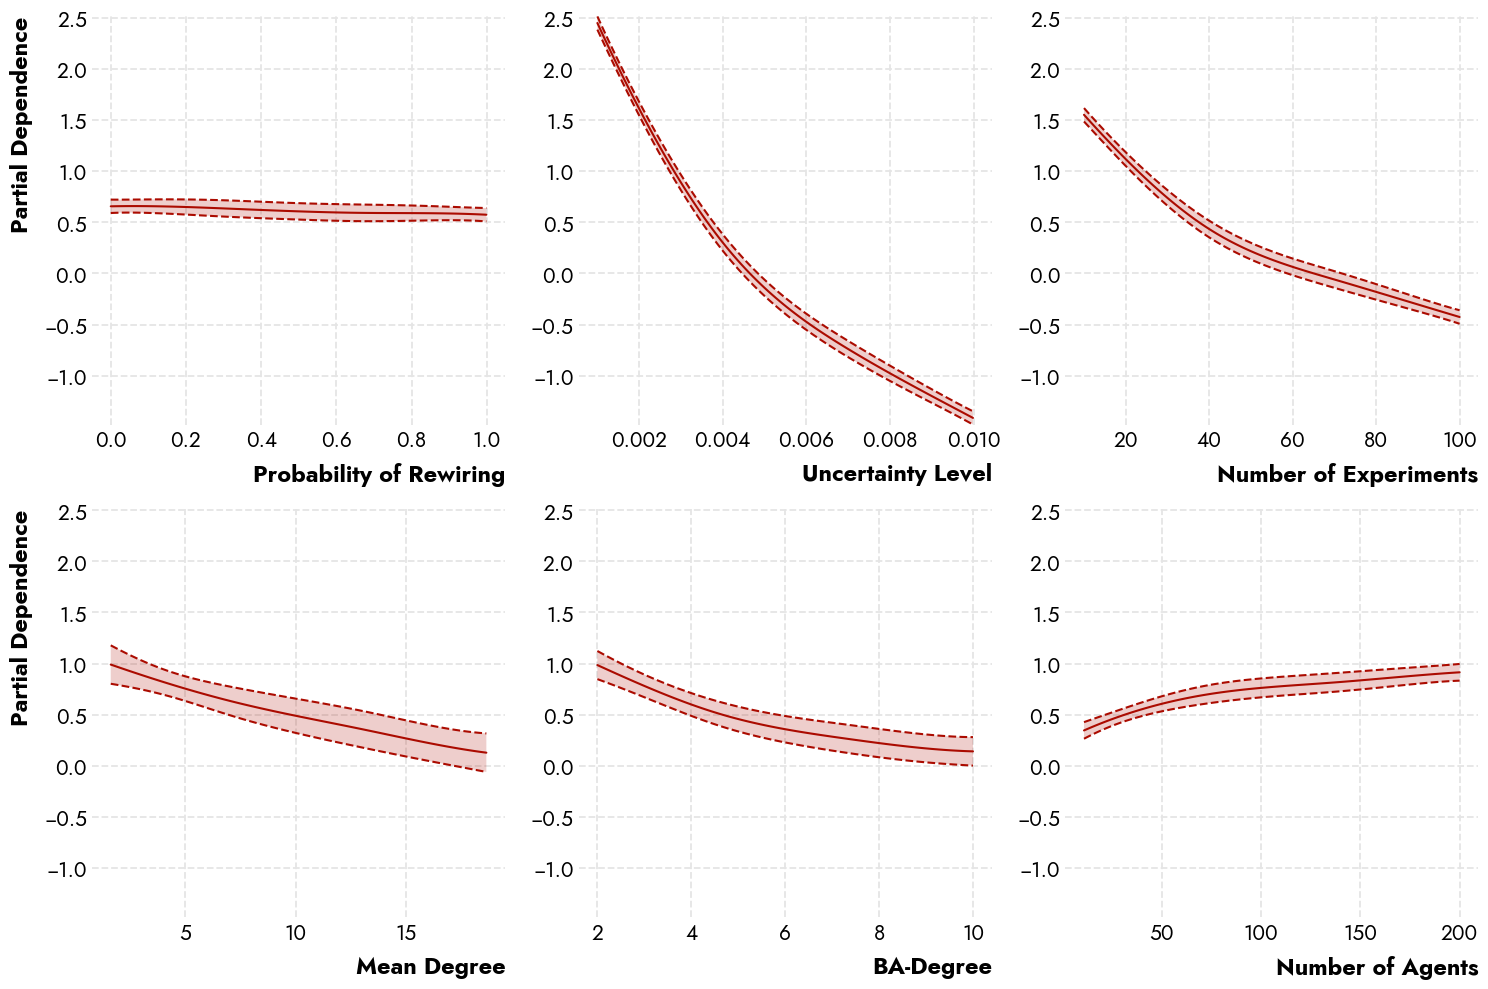

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     19.5321
Link Function:                     IdentityLink Log Likelihood:                                 -5595.1754
Number of Samples:                          990 AIC:                                            11231.4151
                                                AICc:                                           11232.3281
                                                GCV:                                                0.0682
                                                Scale:                                              0.0657
                                                Pseudo R-Squared:                                   0.9648
Feature Function                  Lam

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/3571055282.py:8: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [445]:



# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

# Fitting the Logistic GAM model
gam = LinearGAM(s(0,n_splines=6) + s(1,n_splines=6) + s(2,n_splines=6)+ s(3,n_splines=6)+ s(4,n_splines=6)+ s(5,n_splines=6)  ).fit(X_train, y_train)

plot_partial_dependence(gam,['#ab0b00']*6,X.columns,filename=output_dir + f"bayes_agent_BA_graph_gam_convergence.png")
print(gam.summary())


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     18.7129
Link Function:                     IdentityLink Log Likelihood:                                 -3979.5148
Number of Samples:                          700 AIC:                                             7998.4553
                                                AICc:                                            7999.6575
                                                GCV:                                                0.0681
                                                Scale:                                              0.0649
                                                Pseudo R-Squared:                                   0.9653
Feature Function                  Lam

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/1492959545.py:10: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


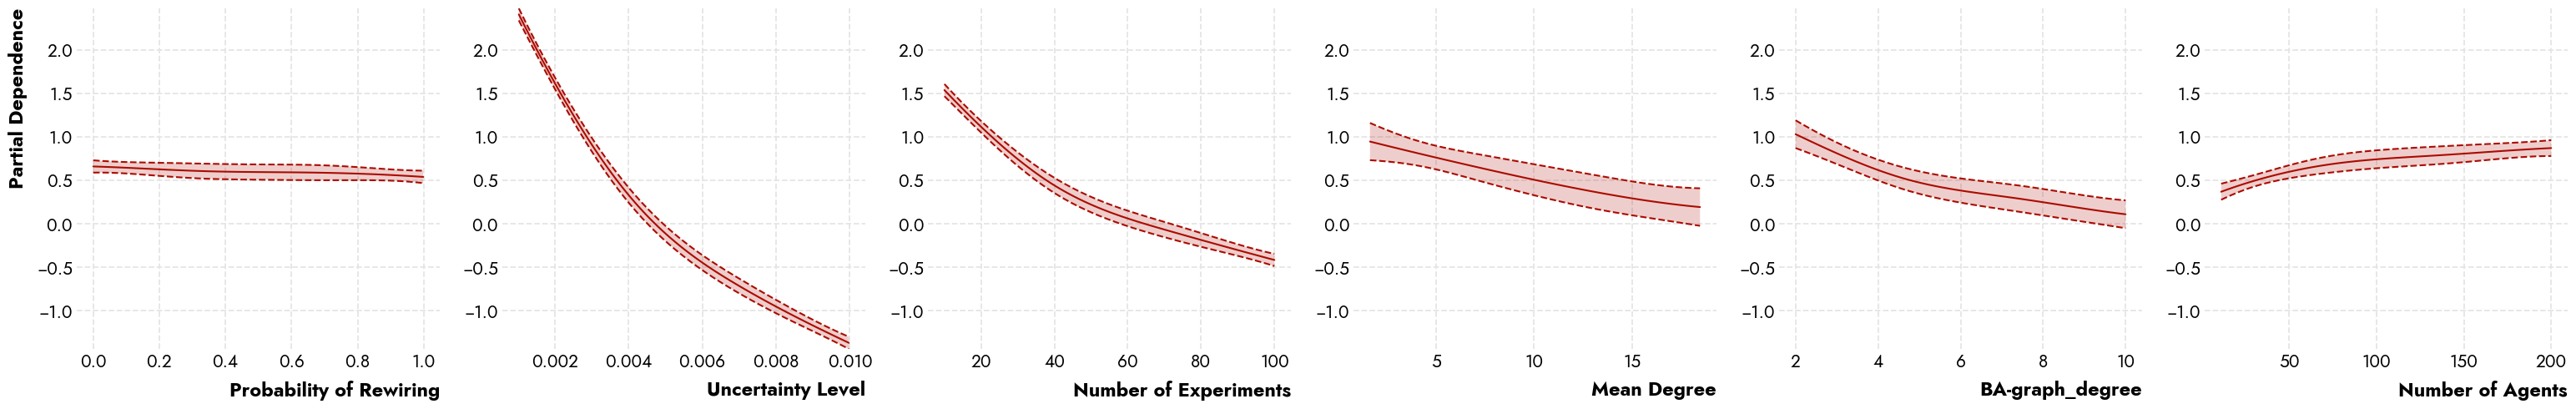

In [264]:



# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fitting the Logistic GAM model
gam = LinearGAM(s(0,n_splines=6) + s(1,n_splines=6) + s(2,n_splines=6) +
                s(3,n_splines=6) + s(4,n_splines=6)+ s(5,n_splines=6)).fit(X_train, y_train)

# print(f"Accuracy on training data: {gam.accuracy(X_train, y_train)}")
# print(f"Accuracy on test data: {gam.accuracy(X_test, y_test)}")
print(gam.summary())
plot_partial_dependence(gam,['#ab0b00']*6,X.columns,filename=output_dir + f"ba_graph_bayes_agent_partial_dependence_convergence_steps.png")


### Watts-Strogatz

In [211]:


    # Preparing the data
X = data_df[['mean_degree','ba_degree', 'p_rewiring', 'uncertainty', 'n_experiments', ]][data_df['network_type']=='ws']
y = data_df['share_of_correct_agents_at_conv'][data_df['network_type']=='ws']



In [212]:

rename_dict = {
    'n_agents': 'Number of Agents',
    'p_rewiring': 'Probability of Rewiring',
    'uncertainty': 'Uncertainty Level',
    'n_experiments': 'Number of Experiments',
    'share_of_correct_agents_at_conv': 'Share of correct agents',
    'mean_degree': 'Mean Degree',
    'ba_degree' : 'WS-neighbors'
}

# Renaming columns in X for better readability
X.rename(columns=rename_dict, inplace=True)

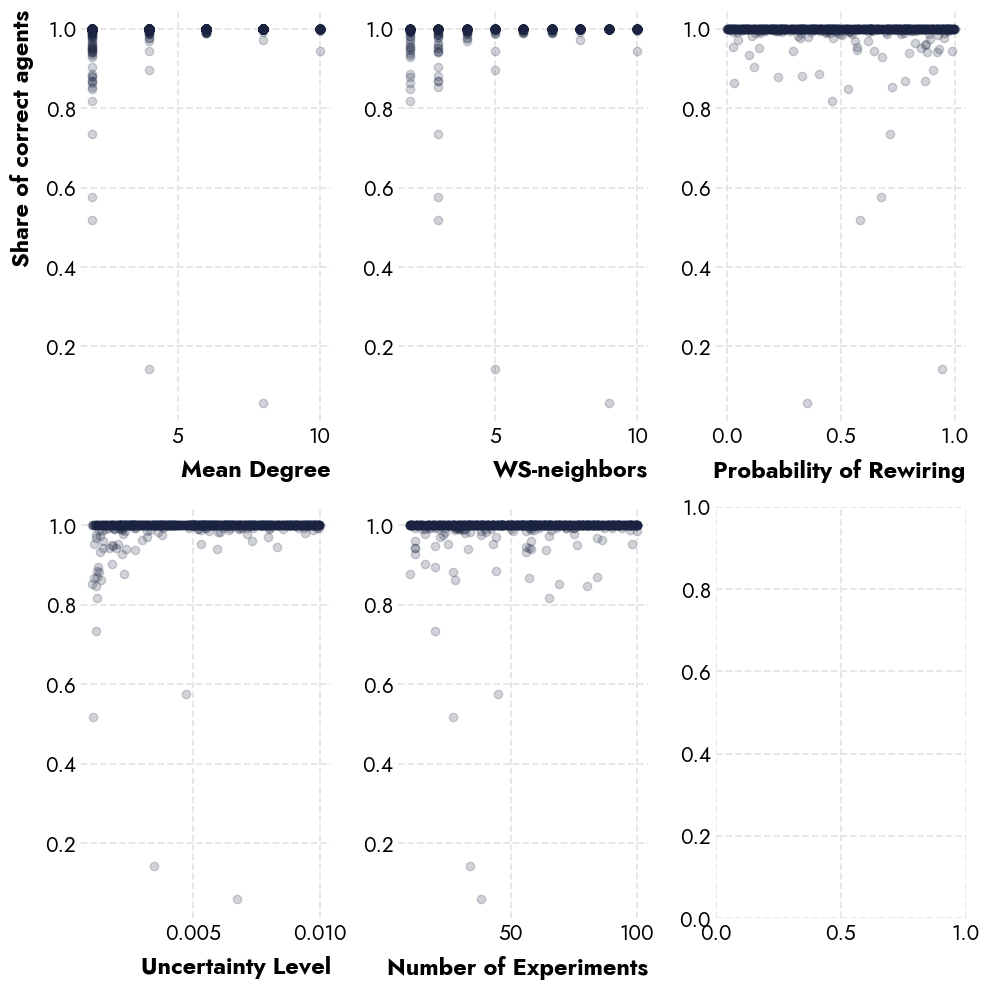

In [213]:

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))  # Adjust the size as needed
axes = axes.ravel()

for i, col in enumerate(X.columns):
    axes[i].scatter(X[col], y, c='#1a2340', alpha=.2)
    axes[i].set_xlabel(rename_dict.get(col, col))  # Use renamed label
    if i == 0:
        axes[i].set_ylabel(rename_dict['share_of_correct_agents_at_conv'])
    #axes[i].set_title(f'{rename_dict.get(col, col)}')

plt.tight_layout()
plt.show()


In [214]:
# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fitting the Logistic GAM model
gam = LinearGAM(s(0,n_splines=6) + s(1,n_splines=6) + s(2,n_splines=6) + s(3,n_splines=6)+ s(4,n_splines=6),
                max_iter=10000,tol=0.00001,verbose=True).fit(X_train, y_train)
#gam.gridsearch(X_train, y_train)
# print(f"Accuracy on training data: {gam.accuracy(X_train, y_train)}")
# print(f"Accuracy on test data: {gam.accuracy(X_test, y_test)}")
print(gam.summary())

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     15.7391
Link Function:                     IdentityLink Log Likelihood:                               -667491.2935
Number of Samples:                          700 AIC:                                          1335016.0653
                                                AICc:                                         1335016.9357
                                                GCV:                                                0.0005
                                                Scale:                                              0.0005
                                                Pseudo R-Squared:                                   0.1404
Feature Function                  Lam

/Users/Noich001/miniforge3/envs/network_epist_playground/lib/python3.12/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/4168073109.py:10: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


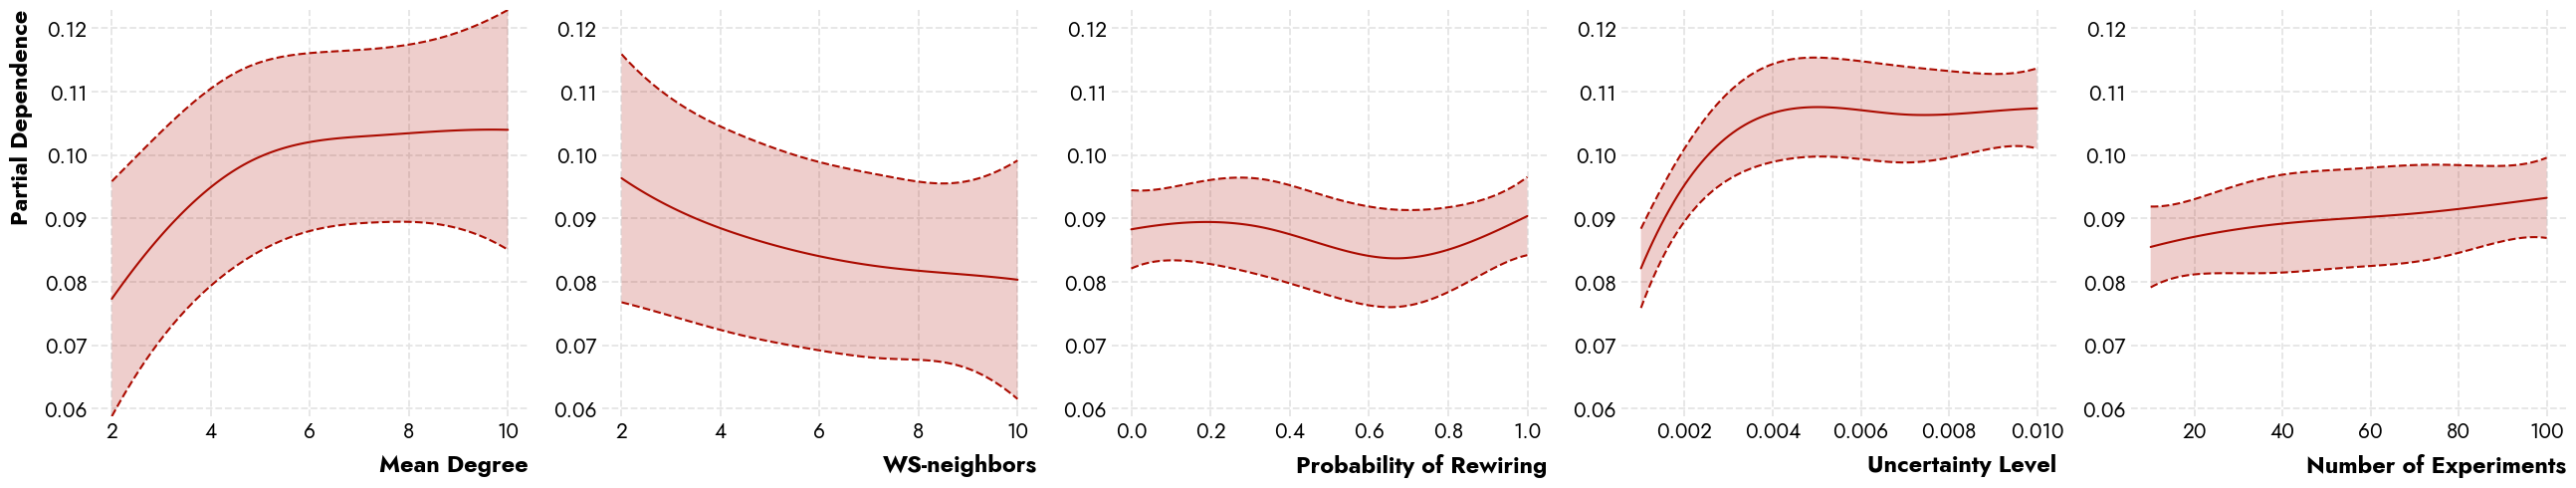

In [215]:
plot_partial_dependence(gam,['#ab0b00']*6,X.columns,filename=output_dir + f"ws_graph_bayes_agent_partial_dependence_.png")

### Powerlaw

In [216]:
data_df

n_agents  ba_degree   er_prob  p_rewiring  uncertainty  n_experiments  \
0           50          3  0.001581    0.314585     0.009161             88   
1          115          6  0.104298    0.934059     0.002747             94   
2           76          5  0.223489    0.998311     0.002316             35   
3           58          3  0.203830    0.041382     0.009668             70   
4          132          2  0.144579    0.650044     0.003101             31   
...        ...        ...       ...         ...          ...            ...   
2995        65          8  0.166648    0.831336     0.001522             61   
2996        22          8  0.236724    0.631580     0.004028             30   
2997       145          4  0.160007    0.177034     0.009306             61   
2998       104          3  0.182446    0.119717     0.001778             16   
2999       138         10  0.195269    0.049671     0.004923             54   

     rewiring_type  mean_degree network_type  true_consensus  \
0        randomize     5.480000           ba        1.000000   
1        randomize    10.973913           ba        1.000000   
2        randomize     9.052632           ba        1.000000   
3        randomize     5.689655           ba        1.000000   
4        randomize     3.909091           ba        0.977273   
...            ...          ...          ...             ...   
2995     randomize     8.000000           ws        1.000000   
2996     randomize     8.000000           ws        1.000000   
2997     randomize     4.000000           ws        1.000000   
2998     randomize     2.000000           ws        0.903846   
2999     randomize    10.000000           ws        1.000000   

      convergence_step agent_type  converged  share_of_correct_agents_at_conv  
0                  123      bayes       True                         1.000000  
1                  574      bayes       True                         1.000000  
2                 1873      bayes       True                         1.000000  
3                  129      bayes       True                         1.000000  
4                 3863      bayes       True                         0.977273  
...                ...        ...        ...                              ...  
2995              2666      bayes       True                         1.000000  
2996               400      bayes       True                         1.000000  
2997               167      bayes       True                         1.000000  
2998             10000      bayes      False                         0.903846  
2999               398      bayes       True                         1.000000  

[3000 rows x 14 columns]

In [217]:

    # Preparing the data
X = data_df[['mean_degree', 'p_rewiring', 'uncertainty', 'n_experiments', ]][data_df['network_type']=='sf']
y = data_df['share_of_correct_agents_at_conv'][data_df['network_type']=='ws']




In [218]:

rename_dict = {
    'n_agents': 'Number of Agents',
    'p_rewiring': 'Probability of Rewiring',
    'uncertainty': 'Uncertainty Level',
    'n_experiments': 'Number of Experiments',
    'share_of_correct_agents_at_conv': 'Share of correct agents',
    'mean_degree': 'Mean Degree',
    'ba_degree' : 'WS-neighbors'
}

# Renaming columns in X for better readability
X.rename(columns=rename_dict, inplace=True)


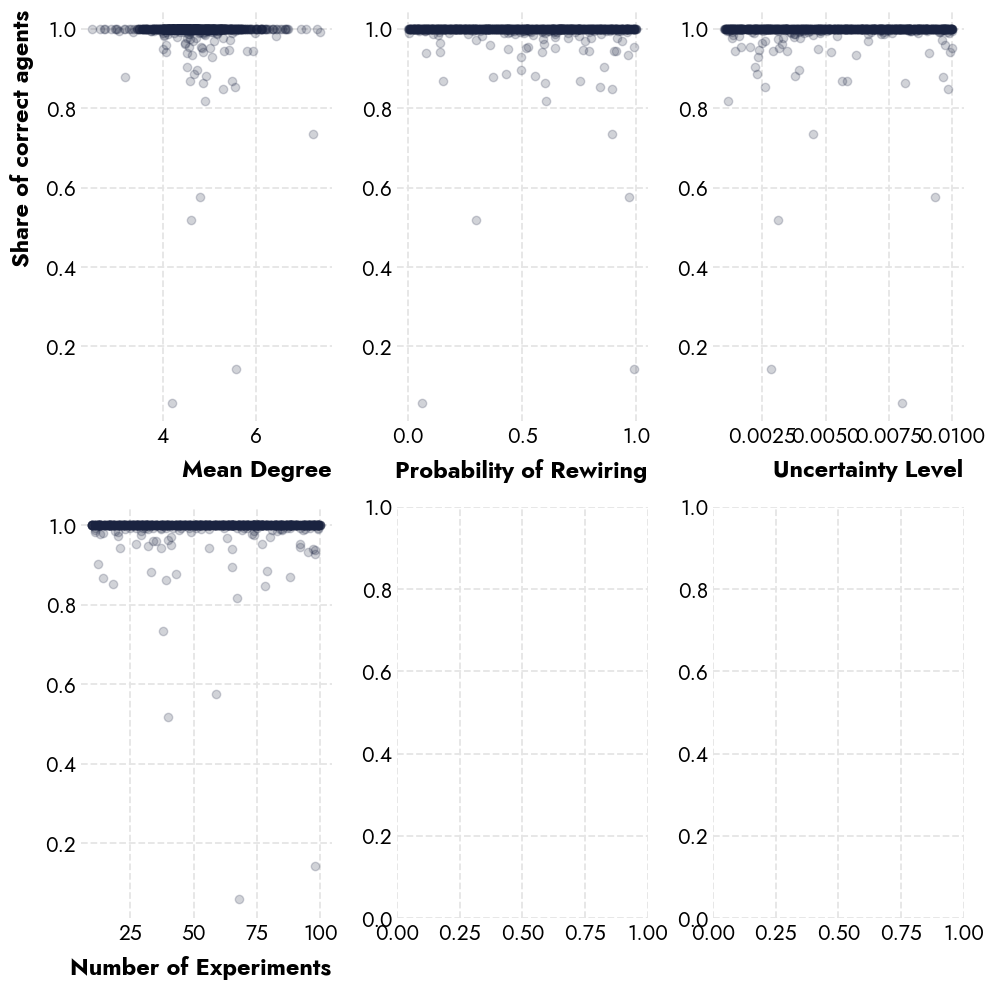

In [219]:

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 10))  # Adjust the size as needed
axes = axes.ravel()

for i, col in enumerate(X.columns):
    axes[i].scatter(X[col], y, c='#1a2340', alpha=.2)
    axes[i].set_xlabel(rename_dict.get(col, col))  # Use renamed label
    if i == 0:
        axes[i].set_ylabel(rename_dict['share_of_correct_agents_at_conv'])
    #axes[i].set_title(f'{rename_dict.get(col, col)}')

plt.tight_layout()
plt.show()




/Users/Noich001/miniforge3/envs/network_epist_playground/lib/python3.12/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)
/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/3031357361.py:11: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     12.6938
Link Function:                     IdentityLink Log Likelihood:                               -599997.2485
Number of Samples:                          700 AIC:                                          1200021.8845
                                                AICc:                                         1200022.4717
                                                GCV:                                                0.0006
                                                Scale:                                              0.0006
                                                Pseudo R-Squared:                                   0.0358
Feature Function                  Lam

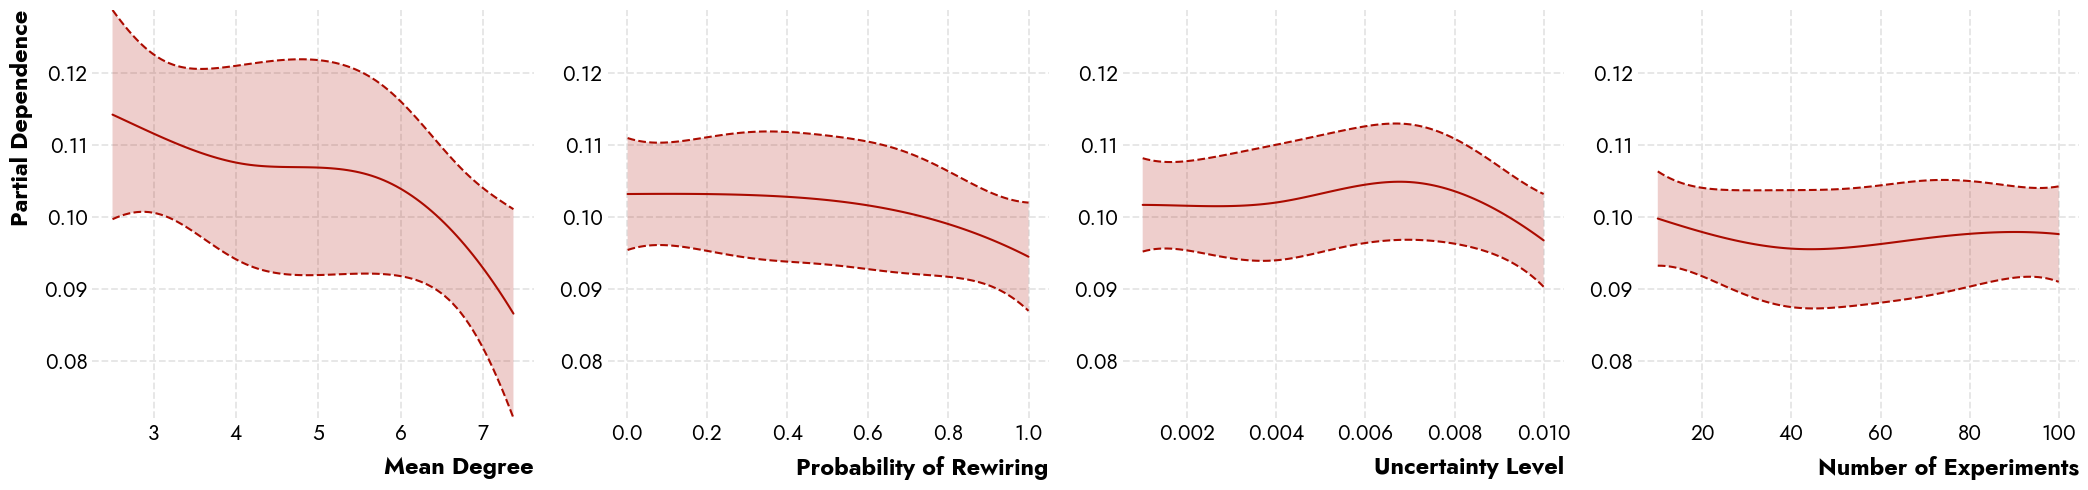

In [220]:


# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Fitting the Logistic GAM model
gam = LinearGAM(s(0,n_splines=6) + s(1,n_splines=6) + s(2,n_splines=6) + s(3,n_splines=6),
                max_iter=10000,tol=0.00001,verbose=True).fit(X_train, y_train)
#gam.gridsearch(X_train, y_train)
# print(f"Accuracy on training data: {gam.accuracy(X_train, y_train)}")
# print(f"Accuracy on test data: {gam.accuracy(X_test, y_test)}")
print(gam.summary())
plot_partial_dependence(gam,['#ab0b00']*6,X.columns,filename=output_dir + f"sf_graph_bayes_agent_partial_dependence_.png")

# Beta-agent-results (artificial networks)


N. unconverged simulations:  567


n_agents  ba_degree   er_prob  p_rewiring  uncertainty  n_experiments  \
0          163          9  0.185345    0.907488     0.001201             23   
1           88          4  0.031889    0.524265     0.008824             22   
2           42          7  0.237598    0.757315     0.001278             33   
3           88          9  0.002981    0.510256     0.003147             83   
4           65          3  0.121248    0.539547     0.008121             86   
...        ...        ...       ...         ...          ...            ...   
1195       117          8  0.180789    0.868345     0.004359             33   
1196       125          6  0.101001    0.088041     0.008944            100   
1197        46          4  0.138221    0.885048     0.008018             29   
1198        29          4  0.042332    0.019795     0.008255             37   
1199        37          7  0.192230    0.056542     0.007730             22   

     rewiring_type  mean_degree network_type  true_consensus  \
0        randomize    16.478528           ba        1.000000   
1        randomize     4.704545           sf        0.806818   
2        randomize     6.000000           ws        1.000000   
3        randomize    15.136364           ba        1.000000   
4        randomize     5.630769           ba        1.000000   
...            ...          ...          ...             ...   
1195     randomize     8.000000           ws        1.000000   
1196     randomize     6.000000           ws        1.000000   
1197     randomize     4.000000           ws        1.000000   
1198     randomize     4.000000           ws        1.000000   
1199     randomize     6.000000           ws        1.000000   

      convergence_step agent_type  converged  share_of_correct_agents_at_conv  
0                10000       beta      False                         1.000000  
1                10000       beta      False                         0.806818  
2                 8465       beta       True                         1.000000  
3                 4965       beta       True                         1.000000  
4                 6970       beta       True                         1.000000  
...                ...        ...        ...                              ...  
1195             10000       beta      False                         1.000000  
1196              6734       beta       True                         1.000000  
1197             10000       beta      False                         1.000000  
1198              6761       beta       True                         1.000000  
1199              7665       beta       True                         1.000000  

[1200 rows x 14 columns]

<Axes: xlabel='convergence_step', ylabel='Count'>

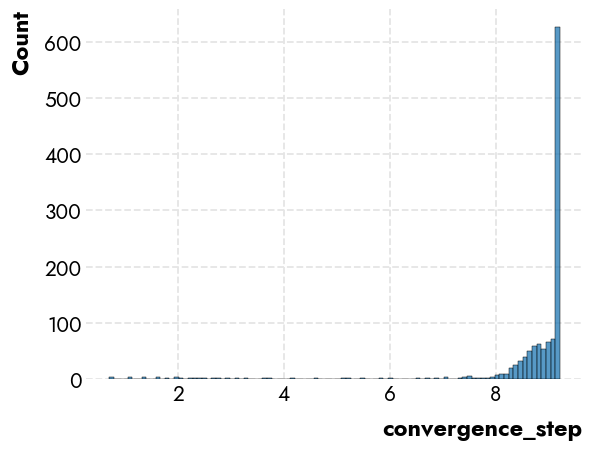

In [455]:

data_df = pd.read_csv('betaagent_results_df.csv')
import dill

data_df['converged'] = data_df['convergence_step']< 10000
print('N. unconverged simulations: ', np.sum(~ data_df['converged']))
data_df['share_of_correct_agents_at_conv'] = data_df['true_consensus']
display(data_df)
import seaborn as sns

sns.histplot(np.log(data_df['convergence_step']))

### Barabasi-Albert-graph


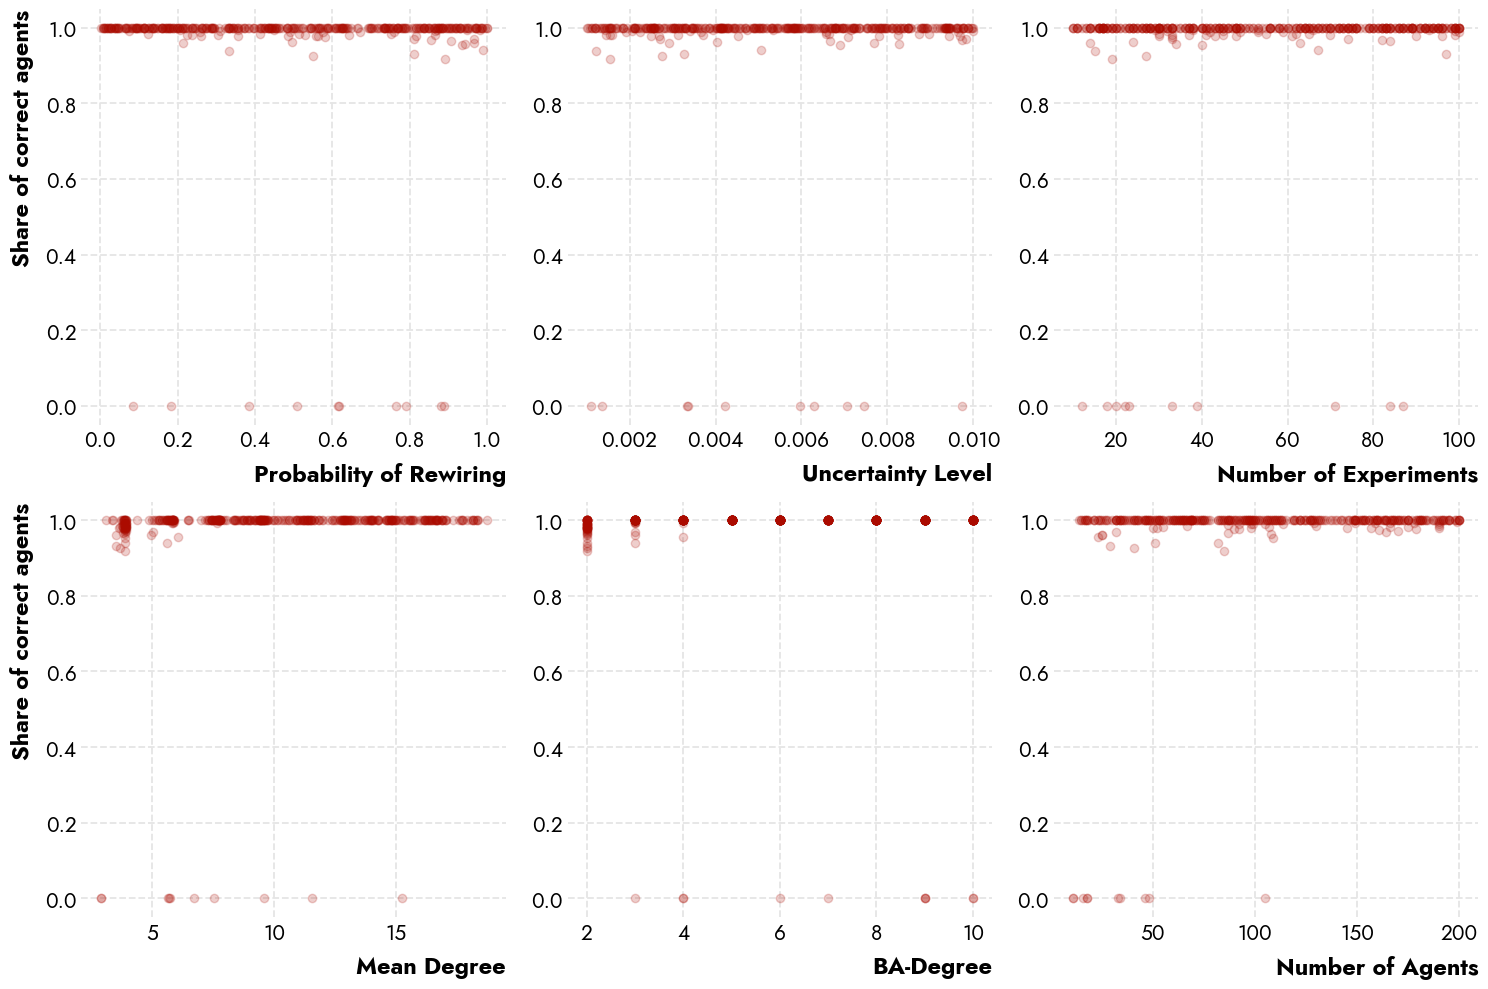

In [456]:



    # Preparing the data
X = data_df[['p_rewiring',	'uncertainty',	'n_experiments', 'mean_degree','ba_degree','n_agents']][data_df['network_type']=='ba']
y = pd.DataFrame(data_df['share_of_correct_agents_at_conv'][data_df['network_type']=='ba'])


X.rename(columns=rename_dict, inplace=True)
y.rename(columns=rename_dict, inplace=True)

plot_scatter_matrix(X, y, max_cols=3, filename=output_dir + 'beta_agent_BA_graph_dat.png')







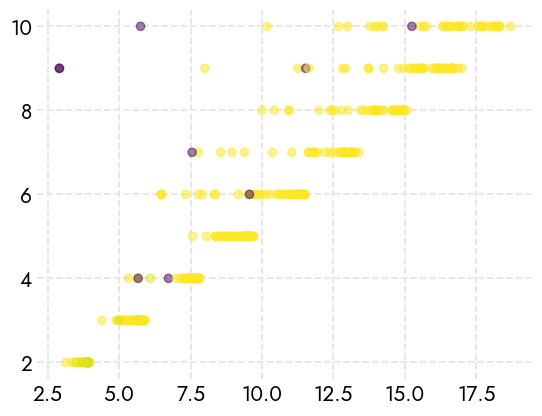

In [462]:
plt.scatter(X['Mean Degree'], X['BA-Degree'],c = y['Share of correct agents'],alpha=.5)

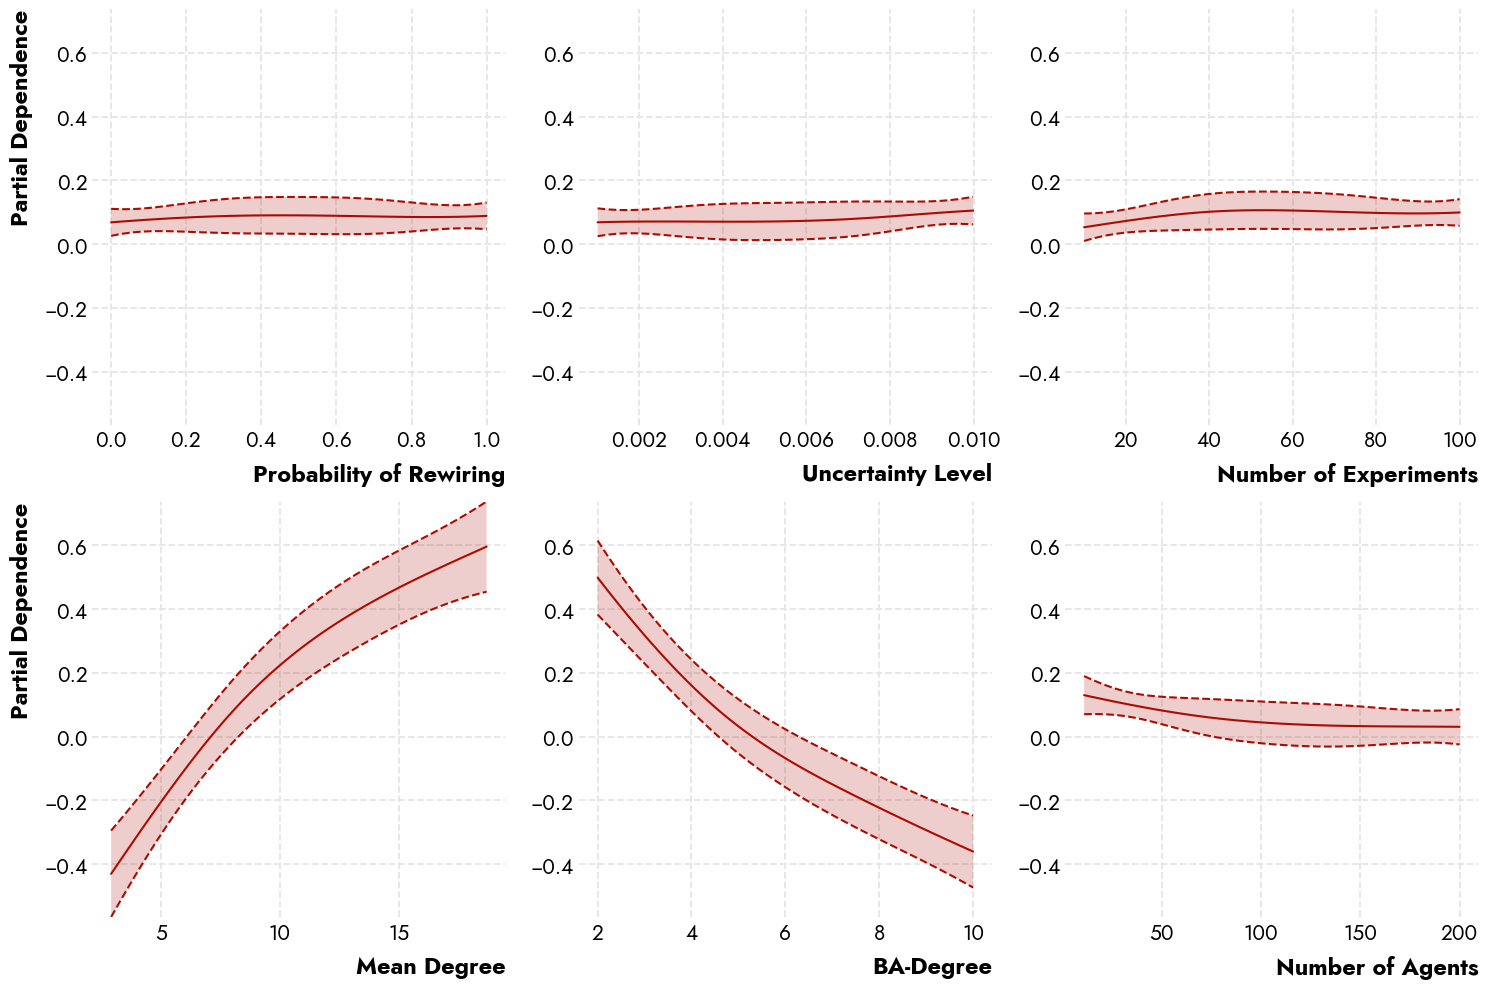

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     17.3933
Link Function:                     IdentityLink Log Likelihood:                                 -9250.2398
Number of Samples:                          396 AIC:                                            18537.2663
                                                AICc:                                           18539.1606
                                                GCV:                                                0.0196
                                                Scale:                                              0.0181
                                                Pseudo R-Squared:                                    0.297
Feature Function                  Lam

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_3358/4218711764.py:8: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


In [457]:



# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

# Fitting the Logistic GAM model
gam = LinearGAM(s(0,n_splines=6) + s(1,n_splines=6) + s(2,n_splines=6)+ s(3,n_splines=6)+ s(4,n_splines=6)+ s(5,n_splines=6)  ).fit(X_train, y_train)

plot_partial_dependence(gam,['#ab0b00']*6,X.columns,filename=output_dir + f"beta_agent_BA_graph_gam.png")
print(gam.summary())


In [463]:
# Use dill to deserialize the graph from a file
with open('data_proc/peptic_ulcer_graph_pre_1978.pkl', 'rb') as f:
    G_ulcer = dill.load(f)


In [464]:
len(G_ulcer)

133403

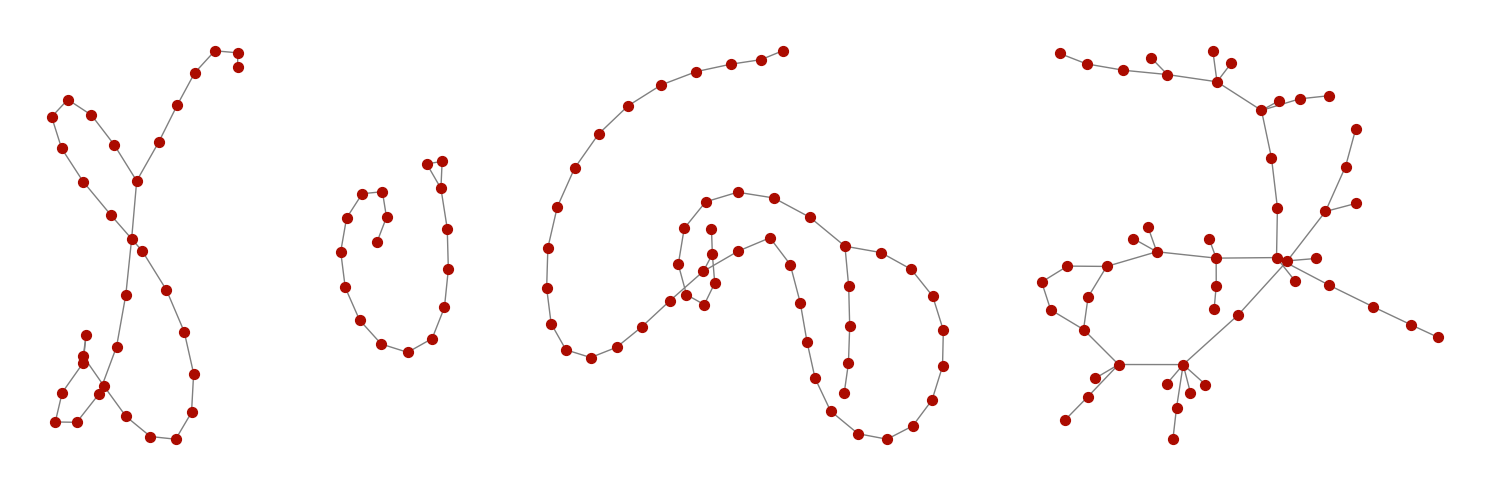

In [622]:
import networkx as nx
import matplotlib.pyplot as plt

# Create a figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Define the parameters for the Watts-Strogatz model
n = 50  # number of nodes
k = 3  # each node is connected to k nearest neighbors in ring topology
p_values = [0.01, 0.1, 0.9]  # probability of rewiring each edge

# Generate and plot the graphs for different probabilities
for i, p in enumerate(p_values):
    # Create a Watts-Strogatz small-world graph
    G = nx.watts_strogatz_graph(n, k, p)
    
    # Draw the graph
    pos_sf = nx.spring_layout(G)
    nx.draw(G, pos_sf, ax=axes[i], node_color='#ab0b00', edge_color='gray', node_size=50)
   # set_title(f"Watts-Strogatz Graph with p={p}")

plt.tight_layout()
plt.show()

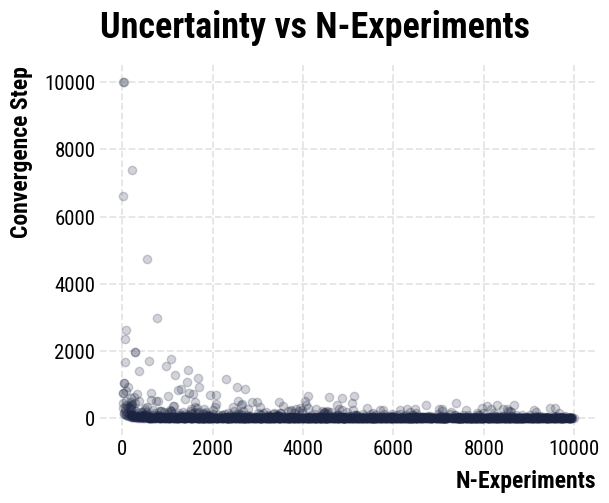

In [17]:
# Creating the scatter plot
plt.scatter(data_df['n_experiments'], data_df['convergence_step'], c='#1a2340',alpha=.2)

# Adding labels and title
plt.xlabel('N-Experiments')  # X-axis label
plt.ylabel('Convergence Step')  # Y-axis label
plt.title('Uncertainty vs N-Experiments')  # Title of the plot

# Show the plot
plt.show()

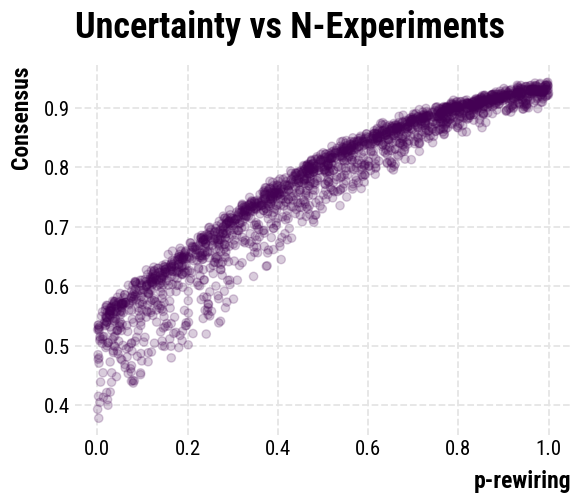

In [20]:
# Creating the scatter plot
plt.scatter(data_df['p_rewiring'], data_df['share_correct_at_convergence'], c=pd.factorize(data_df['rewiring_type'])[0],alpha=.2)

# Adding labels and title
plt.xlabel('p-rewiring')  # X-axis label
plt.ylabel('Consensus')  # Y-axis label
plt.title('Uncertainty vs N-Experiments')  # Title of the plot

# Show the plot
plt.show()

In [ ]:
# Creating the scatter plot
plt.scatter(data_df['p_rewiring'], data_df['true_consensus'], c=pd.factorize(data_df['rewiring_type'])[0],alpha=.2)

# Adding labels and title
plt.xlabel('p-rewiring')  # X-axis label
plt.ylabel('Consensus')  # Y-axis label
plt.title('Uncertainty vs N-Experiments')  # Title of the plot

# Show the plot
plt.show()

# Beta-Agent

In [44]:
data_df = pd.read_csv('betaagent_results_df.csv')

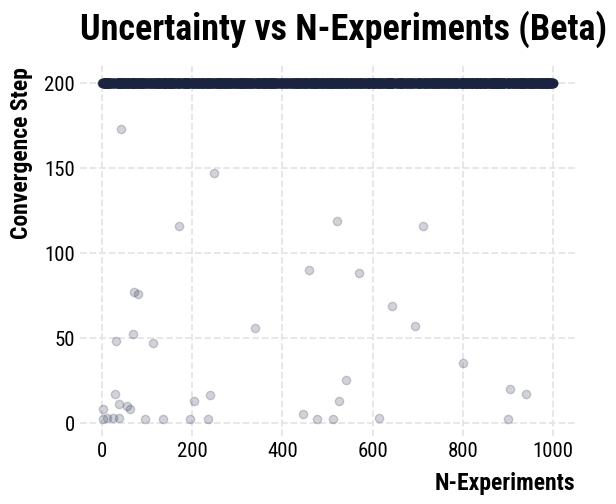

In [47]:
# Creating the scatter plot
plt.scatter(data_df['n_experiments'], data_df['convergence_step'], c='#1a2340',alpha=.2)

# Adding labels and title
plt.xlabel('N-Experiments')  # X-axis label
plt.ylabel('Convergence Step')  # Y-axis label
plt.title('Uncertainty vs N-Experiments (Beta)')  # Title of the plot

# Show the plot
plt.show()

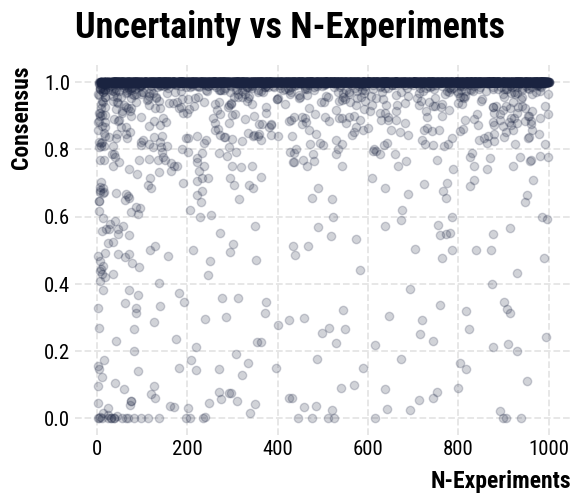

In [46]:
# Creating the scatter plot
plt.scatter(data_df['n_experiments'], data_df['true_consensus'], c='#1a2340',alpha=.2)

# Adding labels and title
plt.xlabel('N-Experiments')  # X-axis label
plt.ylabel('Consensus')  # Y-axis label
plt.title('Uncertainty vs N-Experiments')  # Title of the plot

# Show the plot
plt.show()

In [41]:
!pip install pymc

  Using cached pymc-5.15.1-py3-none-any.whl.metadata (10 kB)
  Using cached arviz-0.18.0-py3-none-any.whl.metadata (8.7 kB)
  Using cached cachetools-5.3.3-py3-none-any.whl.metadata (5.3 kB)
  Using cached pytensor-2.22.1-cp312-cp312-macosx_11_0_arm64.whl
  Using cached rich-13.7.1-py3-none-any.whl.metadata (18 kB)
  Using cached dm_tree-0.1.8-cp312-cp312-macosx_11_0_arm64.whl.metadata (1.9 kB)
  Using cached h5netcdf-1.3.0-py3-none-any.whl.metadata (13 kB)
  Using cached xarray_einstats-0.7.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached etuples-0.3.9-py3-none-any.whl
  Using cached logical_unification-0.4.6-py3-none-any.whl
  Using cached miniKanren-1.0.3-py3-none-any.whl
  Using cached cons-0.4.6-py3-none-any.whl
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached h5py-3.11.0-cp312-cp312-macosx_11_0_arm64.whl.metadata (2.5 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
Using cached pymc-5.15.1-py3-none-any.whl (484 kB)
Using c

In [ ]:
# check powerlaw.

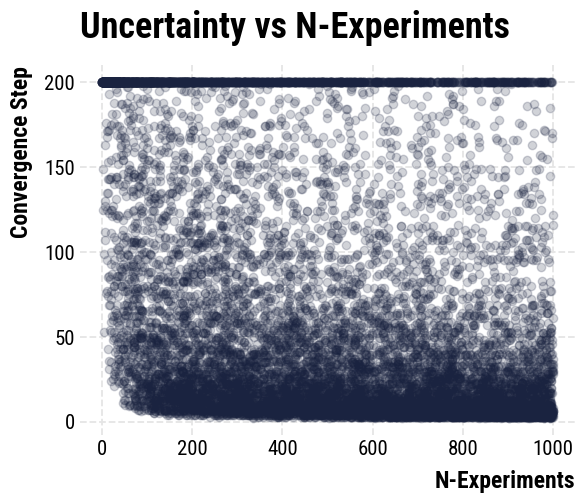

In [38]:
data_df = pd.read_csv('bayesagent_results_df.csv')
# Creating the scatter plot
plt.scatter(data_df['n_experiments'], data_df['convergence_step'], c='#1a2340',alpha=.2)

# Adding labels and title
plt.xlabel('N-Experiments')  # X-axis label
plt.ylabel('Convergence Step')  # Y-axis label
plt.title('Uncertainty vs N-Experiments')  # Title of the plot

# Show the plot
plt.show()

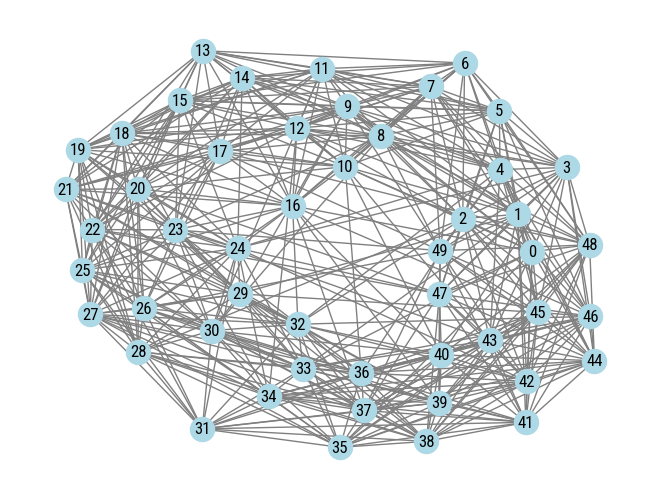

In [365]:
import networkx as nx
import matplotlib.pyplot as plt



# n is the number of nodes
# k is each node is connected to k nearest neighbors in ring topology
# p is the rewiring probability (set to 0 for a regular ring lattice)

n = 50  # number of nodes
k = 2  # each node is connected to 2 nearest neighbors on either side

G = nx.watts_strogatz_graph(n, k, 0.1)

# Draw the graph
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color='gray')
plt.show()

In [9]:


# Splitting the DataFrame by network type
network_types = results_df['network_type'].unique()

my_gams = {}

for network_type in network_types:
    # Subset the DataFrame by network type
    subset = results_df[results_df['network_type'] == network_type]
    
    # Preparing the data
    X = subset[['n_agents']]
    y = subset['true_consensus'].astype(int)  # Convert boolean to integer
    
    # Splitting the data into training and testing sets for model validation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Fitting the Logistic GAM model
    gam = LogisticGAM(s(0,n_splines=6)).fit(X_train, y_train)
    
    # Storing the model
    my_gams[network_type] = gam
    
    # Optionally, you can print out model accuracy or other statistics here
    print(f"Model for {network_type}:")
    print(f"Accuracy on training data: {gam.accuracy(X_train, y_train)}")
    print(f"Accuracy on test data: {gam.accuracy(X_test, y_test)}")
    print("-" * 30)


ModuleNotFoundError: No module named 'pygam'

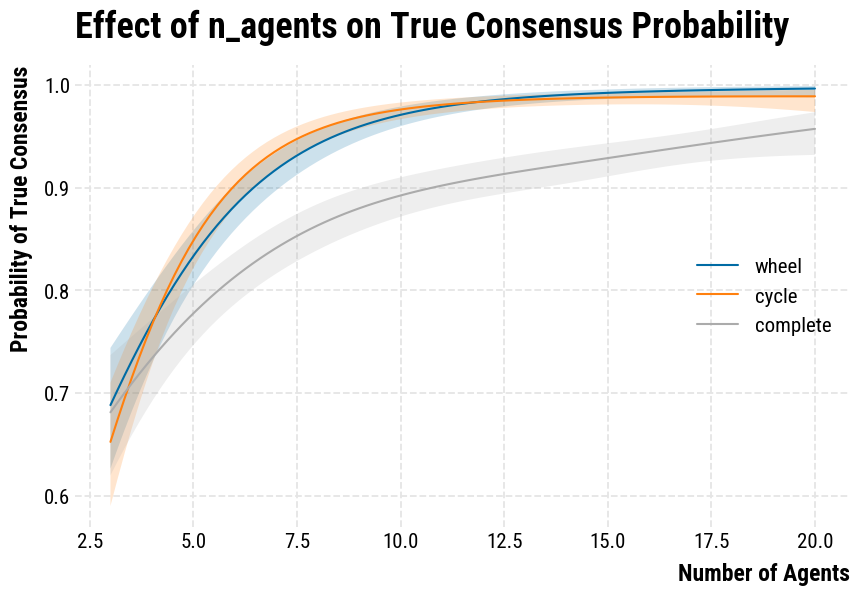

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Set the size of the figure
plt.figure(figsize=(10, 6))


cmap= cmaps.colorblind_10

X_range = np.linspace(X['n_agents'].min(), X['n_agents'].max(), 100)


colors =[cmap(0), cmap(1/cmap.N), cmap(1/cmap.N*2)]

for i, (network_type, gam) in enumerate(my_gams.items()):
    conf = gam.confidence_intervals(X_range.reshape(-1, 1), width=0.95, quantiles=None)
    plt.fill_between(X_range, conf[:, 0], conf[:, 1], facecolor=colors[i], alpha=0.2, interpolate=True)


for i, (network_type, gam) in enumerate(my_gams.items()):
    # Generating a range of values for n_agents to predict and plot
    
    
    # Predicting with the model
    #y_pred, conf = pdep, confi = model.partial_dependence(term=0, width=.95)
    y_pred = gam.predict_proba(X_range.reshape(-1, 1))

    
    # Plotting predicted probabilities
    plt.plot(X_range, y_pred,c=colors[i], label=f'{network_type}')
    
    # Plotting observed data

    # observed_data = results_df[results_df['network_type'] == network_type]
    # plt.scatter(observed_data['n_agents'] + np.random.rand(len(observed_data)), observed_data['true_consensus'], 
    #             alpha=0.01, c='grey',marker=2)


# Adding title, labels, and legend
plt.title('Effect of n_agents on True Consensus Probability')
plt.xlabel('Number of Agents')
plt.ylabel('Probability of True Consensus')
plt.legend()
plt.show()


9

# Tunable networks

In [ ]:
import random
import networkx as nx



def generate_parameters(n):
    params_list = []
    for _ in range(n):
        n_agents = random.randint(3, 15)
        degree = random.randint(1, n_agents-1)
        p_preferential_attachment = random.uniform(0, 1)
        network = create_hybrid_network(n_agents, degree=degree, p_preferential_attachment=p_preferential_attachment)
        uncertainty = 0.001
        n_experiments = 1000 #random.randint(1, 1000)
        params = {
            "n_agents": n_agents,
            "degree": degree,
            "p_preferential_attachment": p_preferential_attachment,
            "network": network,
            "uncertainty": uncertainty,
            "n_experiments": n_experiments
        }
        params_list.append(params)
    return params_list

# Example usage:
# Generate a list of 5 parameter dictionaries
parameter_dictionaries = generate_parameters(50)


In [ ]:
parameter_dictionaries = generate_parameters(10000)  # Generate parameter dictionaries
results_df = batch_run_simulations(parameter_dictionaries, number_of_steps=100000, show_bar=False)
print(results_df)


Running simulations: 100%|██████████| 10000/10000 [01:15<00:00, 132.10it/s]

      n_agents  degree  p_preferential_attachment  uncertainty  n_experiments  \
0            4       2                   0.492210        0.001           1000   
1           12       7                   0.640592        0.001           1000   
2           13       3                   0.805594        0.001           1000   
3            6       5                   0.253219        0.001           1000   
4           11       5                   0.685990        0.001           1000   
...        ...     ...                        ...          ...            ...   
9995         6       5                   0.865813        0.001           1000   
9996        12       7                   0.784926        0.001           1000   
9997         6       2                   0.177675        0.001           1000   
9998         4       2                   0.691931        0.001           1000   
9999         9       1                   0.986273        0.001           1000   

      true_consensus  true_

In [ ]:
 
    # Preparing the data
X = results_df[['n_agents', 'degree', 'p_preferential_attachment']]
y = results_df['true_consensus'].astype(int)  # Convert boolean to integer

# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fitting the Logistic GAM model
gam = LogisticGAM(s(0,n_splines=6) + s(1,n_splines=6) + s(2,n_splines=6) ).fit(X_train, y_train)

print(f"Model for {network_type}:")
print(f"Accuracy on training data: {gam.accuracy(X_train, y_train)}")
print(f"Accuracy on test data: {gam.accuracy(X_test, y_test)}")
print(gam.summary())


Model for complete:
Accuracy on training data: 0.7221428571428572
Accuracy on test data: 0.71
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     10.9616
Link Function:                        LogitLink Log Likelihood:                                 -3795.0395
Number of Samples:                         7000 AIC:                                             7612.0021
                                                AICc:                                            7612.0464
                                                UBRE:                                               3.0887
                                                Scale:                                                 1.0
                                                Ps

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_84390/3925743412.py:14: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


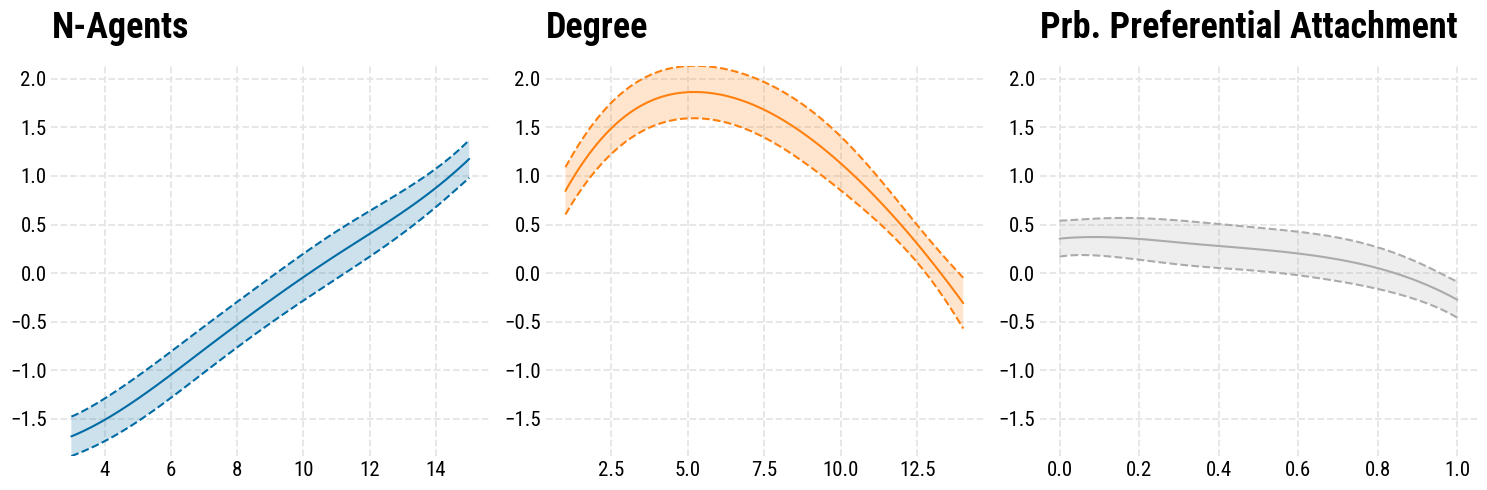

In [ ]:
import matplotlib.pyplot as plt

# Suppose `gam` is your model and `gam.terms` contains the terms used in the model.
# First, determine the number of plots (ignoring the intercept)
plot_count = sum(not term.isintercept for term in gam.terms)

# Start the figure
plt.figure(figsize=(15, 5))  # Adjust the size as needed

current_plot = 1
# Initialize a list to store y-limits
y_limits = []
labels =['N-Agents', 'Degree', 'Prb. Preferential Attachment']
# First pass: compute the y-axis limits for all plots
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    y_limits.append((min(pdep.min(), confi.min()), max(pdep.max(), confi.max())))

# Global y limits
global_y_min = min(limit[0] for limit in y_limits)
global_y_max = max(limit[1] for limit in y_limits)

# Second pass: plot with standardized y limits
current_plot = 1
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    # Set the subplot position
    plt.subplot(1, plot_count, current_plot)
    plt.plot(XX[:, term.feature], pdep,c=colors[i])
    plt.plot(XX[:, term.feature], confi, c=colors[i], ls='--')
    
    plt.fill_between(XX[:, term.feature], confi[:, 0], confi[:, 1], facecolor=colors[i], alpha=0.2, interpolate=True)

    plt.ylim(global_y_min, global_y_max)  # Set global y limits
    plt.title(labels[i])
    plt.xlabel('')  # Remove x-axis label
    plt.ylabel('')  # Remove y-axis label


    current_plot += 1  # Move to the next plot position

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()


# Randomized networks

In [94]:
import random
import networkx as nx
from hybrid_networks import randomized_barabasi_albert_graph

def generate_parameters(n):
    params_list = []
    for _ in range(n):
        n_agents = random.randint(3, 100)
        n_edges_to_add = random.randint(1, np.max([int(n_agents/10),1])) #rethink
        randomization_probability = random.uniform(0, 1)
        network = randomized_barabasi_albert_graph(n_agents, 
                                                    n_edges_to_add=n_edges_to_add, 
                                                    randomization_probability=randomization_probability)
        uncertainty = 0.001
        n_experiments = 1000 #random.randint(1, 1000)
        params = {
            "n_agents": n_agents,
            "n_edges_to_add": n_edges_to_add,
            "randomization_probability": randomization_probability,
            "network": network,
            "uncertainty": uncertainty,
            "n_experiments": n_experiments
        }
        params_list.append(params)
    return params_list

# Example usage:
# Generate a list of 5 parameter dictionaries
parameter_dictionaries = generate_parameters(50)




In [95]:
parameter_dictionaries

[{'n_agents': 6,
  'n_edges_to_add': 1,
  'randomization_probability': 0.3066215272629732,
  'network': <networkx.classes.graph.Graph at 0x2f604c890>,
  'uncertainty': 0.001,
  'n_experiments': 1000},
 {'n_agents': 4,
  'n_edges_to_add': 1,
  'randomization_probability': 0.21376908591860166,
  'network': <networkx.classes.graph.Graph at 0x2f604c390>,
  'uncertainty': 0.001,
  'n_experiments': 1000},
 {'n_agents': 64,
  'n_edges_to_add': 6,
  'randomization_probability': 0.5756424007939364,
  'network': <networkx.classes.graph.Graph at 0x2b9d8fb90>,
  'uncertainty': 0.001,
  'n_experiments': 1000},
 {'n_agents': 67,
  'n_edges_to_add': 6,
  'randomization_probability': 0.8849150780526577,
  'network': <networkx.classes.graph.Graph at 0x2b9a67fd0>,
  'uncertainty': 0.001,
  'n_experiments': 1000},
 {'n_agents': 44,
  'n_edges_to_add': 3,
  'randomization_probability': 0.46759915539183294,
  'network': <networkx.classes.graph.Graph at 0x2b9d85b10>,
  'uncertainty': 0.001,
  'n_experiments

{'n_agents': 6, 'n_edges_to_add': 1, 'randomization_probability': 0.3066215272629732, 'network': <networkx.classes.graph.Graph object at 0x2f604c890>, 'uncertainty': 0.001, 'n_experiments': 1000}


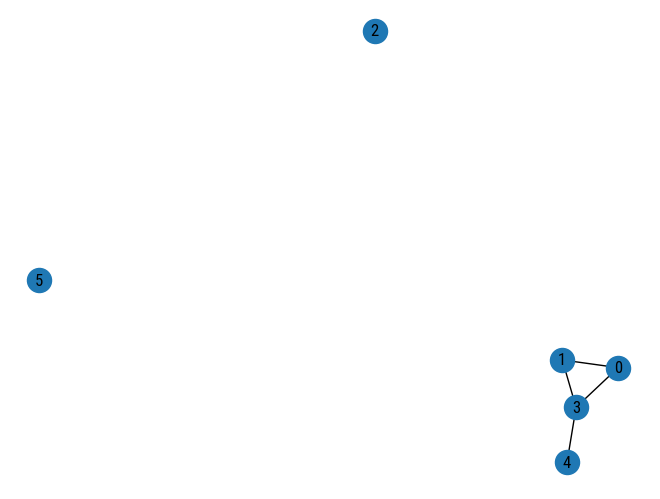

In [96]:
import networkx as nx
import matplotlib.pyplot as plt

# Get the network from the parameter dictionary
params = parameter_dictionaries[0]
print(params)
network = params['network']

# Create a graph from the network
graph = nx.Graph(network)

# Plot the graph
nx.draw(graph, with_labels=True)
plt.show()


In [97]:
parameter_dictionaries = generate_parameters(10000)  # Generate parameter dictionaries
results_df = run_simulations(parameter_dictionaries, number_of_steps=100000, show_bar=False)
display(results_df)


Running simulations: 100%|██████████| 10000/10000 [09:41<00:00, 17.18it/s]


n_agents  n_edges_to_add  randomization_probability  uncertainty  \
0           35               1                   0.465802        0.001   
1            7               1                   0.126811        0.001   
2           39               3                   0.870653        0.001   
3            8               1                   0.697600        0.001   
4           64               2                   0.709067        0.001   
...        ...             ...                        ...          ...   
9995        44               4                   0.453453        0.001   
9996        16               1                   0.161439        0.001   
9997        67               2                   0.138573        0.001   
9998        36               3                   0.367534        0.001   
9999       100               5                   0.997589        0.001   

      n_experiments  true_consensus  true_consensus_alternative_stop  
0              1000        0.828571                         0.828571  
1              1000        1.000000                         1.000000  
2              1000        1.000000                         1.000000  
3              1000        0.875000                         0.875000  
4              1000        0.968750                         0.968750  
...             ...             ...                              ...  
9995           1000        1.000000                         1.000000  
9996           1000        1.000000                         1.000000  
9997           1000        1.000000                         1.000000  
9998           1000        1.000000                         1.000000  
9999           1000        1.000000                         1.000000  

[10000 rows x 7 columns]

In [98]:

 
    # Preparing the data
X = results_df[['n_agents', 'n_edges_to_add', 'randomization_probability']]
y = results_df['true_consensus'].astype(int)  # Convert boolean to integer

# Splitting the data into training and testing sets for model validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Fitting the Logistic GAM model
gam = LogisticGAM(s(0,n_splines=6) + s(1,n_splines=6) + s(2,n_splines=6) ).fit(X_train, y_train)

print(f"Model for {network_type}:")
print(f"Accuracy on training data: {gam.accuracy(X_train, y_train)}")
print(f"Accuracy on test data: {gam.accuracy(X_test, y_test)}")
print(gam.summary())

Model for complete:
Accuracy on training data: 0.8481428571428572
Accuracy on test data: 0.8496666666666667
LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                      9.5573
Link Function:                        LogitLink Log Likelihood:                                 -2388.4934
Number of Samples:                         7000 AIC:                                             4796.1014
                                                AICc:                                            4796.1363
                                                UBRE:                                               2.6862
                                                Scale:                                                 1.0
                                    

/var/folders/hz/4s_tpd8s47xfzz7rhhfjdbb00000gn/T/ipykernel_84390/2392922359.py:14: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


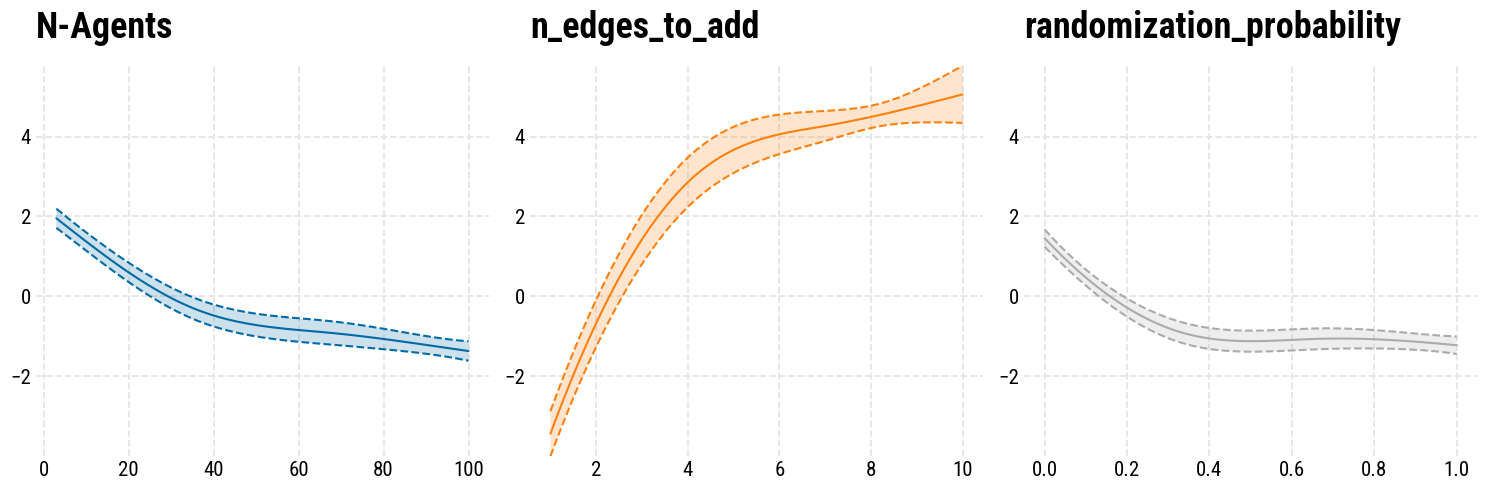

In [99]:
import matplotlib.pyplot as plt

# Suppose `gam` is your model and `gam.terms` contains the terms used in the model.
# First, determine the number of plots (ignoring the intercept)
plot_count = sum(not term.isintercept for term in gam.terms)

# Start the figure
plt.figure(figsize=(15, 5))  # Adjust the size as needed

current_plot = 1
# Initialize a list to store y-limits
y_limits = []
labels =['N-Agents', 'n_edges_to_add', 'randomization_probability']
# First pass: compute the y-axis limits for all plots
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    y_limits.append((min(pdep.min(), confi.min()), max(pdep.max(), confi.max())))

# Global y limits
global_y_min = min(limit[0] for limit in y_limits)
global_y_max = max(limit[1] for limit in y_limits)

# Second pass: plot with standardized y limits
current_plot = 1
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    # Set the subplot position
    plt.subplot(1, plot_count, current_plot)
    plt.plot(XX[:, term.feature], pdep,c=colors[i])
    plt.plot(XX[:, term.feature], confi, c=colors[i], ls='--')
    
    plt.fill_between(XX[:, term.feature], confi[:, 0], confi[:, 1], facecolor=colors[i], alpha=0.2, interpolate=True)

    plt.ylim(global_y_min, global_y_max)  # Set global y limits
    plt.title(labels[i])
    plt.xlabel('')  # Remove x-axis label
    plt.ylabel('')  # Remove y-axis label


    current_plot += 1  # Move to the next plot position

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()
